# Various Positions Test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib

from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Plots import lens_plot, plot_util
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Util import param_util, image_util
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy.Util.param_util as param_util
from multiprocessing import Pool


from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
import lenstronomy.ImSim.de_lens as de_lens
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
# Import PySwarms
import pyswarms as ps
import copy
import pickle


from astropy.cosmology import Planck15 as cosmo



nmax1 = 8
nmax2 = 8

cnk = 1

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 80}
matplotlib.rc('font', **font)

matplotlib.rcParams['axes.linewidth'] = 2.5

deltaPix = 0.031230659851709842*cnk  #  pixel size in arcsec (area per pixel = deltaPix**2)
exp_time = 1.
sigma_bkg = 1.

array200sci = np.load('../smacs_0723/f200w_image1_.npy')
array200err = np.load('../smacs_0723/f200w_error1_.npy')

array200sci2 = np.load('../smacs_0723/f200w_image2_.npy')
array200err2 = np.load('../smacs_0723/f200w_error2_.npy')

array200sci3 = np.load('../smacs_0723/f200w_image3_.npy')
array200err3 = np.load('../smacs_0723/f200w_error3_.npy')

##############################
#errorfixin
for i in range(len(array200err)):
    for j in range(len(array200err)):
        if array200err[i,j] == 0:
            array200err[i,j] = np.inf
        if array200err2[i,j] == 0:
            array200err2[i,j] = np.inf
        if array200err3[i,j] == 0:
            array200err3[i,j] = np.inf
##############################


def rechunk(array2d,nchunk):
    shp = np.shape(array2d)
    shpnew = [int(q/nchunk) for q in shp]
    arraynew = np.zeros(shpnew)
    
    for i in range(shpnew[0]):
        for j in range(shpnew[1]):
            for k in range(nchunk):
                for l in range(nchunk):
                    arraynew[i,j] += array2d[i*nchunk+k,j*nchunk+l]/(nchunk**2.) 
    return arraynew

def rechunkerr(array2d,nchunk):
    shp = np.shape(array2d)
    shpnew = [int(q/nchunk) for q in shp]
    arraynew = np.zeros(shpnew)
    
    for i in range(shpnew[0]):
        for j in range(shpnew[1]):
            acc = 0.
            for k in range(nchunk):
                for l in range(nchunk):
                    acc += (array2d[i*nchunk+k,j*nchunk+l]/(nchunk**2.))**2.
            arraynew[i,j] = np.sqrt(acc)
    return arraynew

arytst = rechunk(array200sci,cnk)
arytst2 = rechunk(array200sci2,cnk)
arytst3 = rechunk(array200sci3,cnk)

arytsterr = rechunkerr(array200err,cnk)
arytsterr2 = rechunkerr(array200err2,cnk)
arytsterr3 = rechunkerr(array200err3,cnk)

numPix2 = int(120/cnk)

kernel_cut = np.load('../jwst_psf_200.npy')

print(np.shape(kernel_cut))
for i in range(91):
    for j in range(91):
        if kernel_cut[i,j] < 0:
            kernel_cut[i,j] = 0.

psf_type = 'NONE'  # 'GAUSSIAN', 'PIXEL', 'NONE'

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix/cnk,'kernel_point_source': kernel_cut}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)

psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 1}

kwargs_data2 = sim_util.data_configure_simple(numPix2, deltaPix, exp_time, sigma_bkg)
data_class2 = ImageData(**kwargs_data2)

def makemask(array,a,b,angle):
    #makes an elliptical mask of a size and angle
    shp = np.shape(array)
    
    likemask = np.zeros(shp,dtype=np.bool)
    for i in range(shp[0]):
        for j in range(shp[1]):
            xprim = np.cos(angle)*(i-shp[0]/2.) + np.sin(angle)*(j-shp[1]/2.)
            yprim = np.cos(angle)*(j-shp[1]/2.) - np.sin(angle)*(i-shp[0]/2.)
            sqrsum = (xprim/a)**2 + (yprim/b)**2. 
            if sqrsum < 1:
                likemask[i,j] = True
    return likemask

def convert_params(mur,mut):
    #take in the tangential and radial magnification
    #return kappa and gamma
    kappa = 1. - 0.5*(1./mur + 1./mut)
    gamma = 0.5*(1./mur - 1./mut)
    return kappa,gamma

likemask = makemask(arytst,35./cnk,85./cnk,1.85)
likemask2 = makemask(arytst2,35/cnk,85./cnk,2.25)
likemask3 = makemask(arytst3,35/cnk,45./cnk,2.25)

def flatten2d(arrays,likemasks):
    #flattens a set of arrays according to likemasks
    flatarr = []
    for i in range(len(likemasks)):
        for p in range(len(likemasks[i])):
            for q in range(len(likemasks[i])):
                if likemasks[i][p,q]:
                    flatarr.append(arrays[i][p,q])  
    return flatarr

def unflatten(flatimg,likemasks):
    arrays = np.zeros([len(likemasks),len(likemasks[0]),len(likemasks[0])])
    k = 0
    for i in range(len(likemasks)):
        for p in range(len(likemasks[i])):
            for q in range(len(likemasks[i])):
                if likemasks[i][p,q]:
                    arrays[i,p,q] = flatimg[k]
                    k+=1
    return arrays

imagearr = np.array([arytst3,arytst2,arytst])
noises = np.array([arytsterr3,arytsterr2,arytsterr])
likemasks = np.array([likemask3,likemask2,likemask])
likearr = likemasks

flatarr = flatten2d(imagearr,likemasks)
flaterror = flatten2d(noises,likemasks)

indices = [0,1,2]

for i in range(len(flaterror)):
    if flaterror[i] == 0:
        flaterror[i] = np.inf

unflatimg = unflatten(flatarr,likemasks)

def model_curved_fit_shapelet_sers(data,kappashear_params,redshift_list,is_background,z_src,source_params,likemask_list,indices):   
    A_list = []
    C_D_response_list = []
    d_list = []
    for i in indices:
    # the lens model is a supperposition of an elliptical lens model with external shear
        if i == 1:
            redshift_list_plug = redshift_list
            if is_background:
                lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST','NFW']
            else:
                lens_model_list_new = ['SHIFT','NFW','CURVED_ARC_SIS_MST']
        else:
            redshift_list_plug = [0.01,0.3877]
            lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST']
            
        
        
            
        kwargs_lens_true_new = kappashear_params[i]

        lens_model_class = LensModel(lens_model_list=lens_model_list_new, z_source=z_src, 
                             lens_redshift_list=redshift_list_plug, multi_plane=True)

        source_model_list = ['SHAPELETS','SHAPELETS']
        source_model_class = LightModel(light_model_list=source_model_list)
        
        lensLightModel_reconstruct = LightModel([])

        data_class2.update_data(data[i])
        
        imageModel = ImageLinearFit(data_class=data_class2, psf_class=psf_class, kwargs_numerics=kwargs_numerics, 
                                lens_model_class=lens_model_class, source_model_class=source_model_class,
                                lens_light_model_class = lensLightModel_reconstruct,likelihood_mask=likemask_list[i])
        
        
        A = imageModel._linear_response_matrix(kwargs_lens_true_new, source_params, kwargs_lens_light=[], kwargs_ps=None)
        C_D_response, model_error = imageModel._error_response(kwargs_lens_true_new, kwargs_ps=None,kwargs_special=None)
        d = imageModel.data_response
        
        A_list.append(A)
        
        Ashp = np.shape(A)
        
        C_D_response_list.append(C_D_response)
        d_list.append(d)
    
    Ashp = np.shape(A)
        
    
    Atot = np.concatenate((A_list),axis=1)
    Ctot = np.concatenate((C_D_response_list))
    Dtot = np.concatenate((d_list))
    
    param, cov_param, wls_model2 = de_lens.get_param_WLS(Atot.T, 1./Ctot, Dtot, inv_bool=False)
    
    return wls_model2,param

ndeg = np.count_nonzero(likemasks)

def create_curved_fit_shapelet_sers(param,kappashear_params,redshift_list,is_background,z_src,source_params,indices):   
    image_list = []
    for i in indices:
    # the lens model is a supperposition of an elliptical lens model with external shear
        if i == 1:
            redshift_list_plug = redshift_list
            if is_background:
                lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST','NFW']
            else:
                lens_model_list_new = ['SHIFT','NFW','CURVED_ARC_SIS_MST']
        else:
            redshift_list_plug = [0.01,0.3877]
            lens_model_list_new = ['SHIFT','CURVED_ARC_SIS_MST']
        kwargs_lens_true_new = kappashear_params[i]

        lens_model_class = LensModel(lens_model_list=lens_model_list_new, z_source=z_src, 
                             lens_redshift_list=redshift_list_plug, multi_plane=True)

        source_model_list = ['SHAPELETS','SHAPELETS']
        source_model_class = LightModel(light_model_list=source_model_list)
        
        lensLightModel_reconstruct = LightModel([])
        
        imageModel = ImageModel(data_class2, psf_class, lens_model_class, source_model_class, kwargs_numerics=kwargs_numerics)

        source_params0 = copy.deepcopy(source_params[0])
        source_params0['amp'] = param[:int(len(param)/2)]

        source_params1 = copy.deepcopy(source_params[1])
        source_params1['amp'] = param[int(len(param)/2):]
        
        image_sim = imageModel.image(kwargs_lens_true_new, [source_params0,source_params1])
        
        image_list.append(image_sim)
        
    return np.array(image_list)

(91, 91)


<ipython-input-1-33f4d6d0ff85>:134: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  likemask = np.zeros(shp,dtype=np.bool)


In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f) 

In [3]:
dresults = load_obj('../smacs_0723/narrower_priors_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')

In [4]:
def plot_true_source(source_kwargs,param):
    # data specifics
    exp_time = 1000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix = 1000  #  cutout pixel size
    deltaPix = 0.002  #  pixel size in arcsec (area per pixel = deltaPix**2)
    fwhm = 4e-2  # full width half max of PSF (only valid when psf_type='gaussian')
    psf_type = 'PIXEL'  # 'GAUSSIAN', 'PIXEL', 'NONE'
    # generate the psf variables
    kernel_cut = np.zeros([15,15])
    kernel_cut[7,7] = 1.
    kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm, 'kernel_point_source':kernel_cut}
    #kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
    psf_class = PSF(**kwargs_psf)
    
    # generate the coordinate grid and image properties
    kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
    kwargs_data['exposure_time'] = exp_time * np.ones_like(kwargs_data['image_data'])
    data_class = ImageData(**kwargs_data)
    # keywords for PixelGrid() class used in plotting routines
    kwargs_pixel_grid = {'nx': numPix, 'ny': numPix, 'transform_pix2angle': kwargs_data['transform_pix2angle'],
                         'ra_at_xy_0': kwargs_data['ra_at_xy_0'], 'dec_at_xy_0': kwargs_data['dec_at_xy_0']}
 
    # the lens model is a supperposition of an elliptical lens model with external shear
    lens_model_list_new = []
    kwargs_lens_true_new = []

    lens_model_class = LensModel(lens_model_list=lens_model_list_new)

    source_model_list = ['SHAPELETS','SHAPELETS']
    source_model_class = LightModel(light_model_list=source_model_list)
    
    source_params0 = copy.deepcopy(source_kwargs[0])
    source_params0['amp'] = param[:int(len(param)/2)]
    
    source_params1 = copy.deepcopy(source_kwargs[1])
    source_params1['amp'] = param[int(len(param)/2):]
    
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, kwargs_numerics=kwargs_numerics)

    # generate image
    image_sim = imageModel.image(kwargs_lens_true_new, [source_params0,source_params1])
        
    return image_sim


def makemock(params,paramq,mass,concen,z_int,xper,yper):    
    mur1, mut1 = 1.,params[0]
    mur2, mut2 = params[3],params[4]
    mur3, mut3 = params[9],params[10]
    
    cv1 = np.abs(params[1])
    cv2 = np.abs(params[5])
    cv3 = np.abs(params[11])

    psi_ext1 = params[2]*np.pi - (np.sign(params[1])+1.)*np.pi/2.
    psi_ext2 = params[6]*np.pi - (np.sign(params[5])+1.)*np.pi/2.
    psi_ext3 = params[12]*np.pi - (np.sign(params[11])+1.)*np.pi/2.
    
    # lensing quantities
    Mpert = mass
    Cpert = concen

    z_s = 1.449
    z_l = 0.3877
        
    is_background = z_int > z_l

    lens_cosmo = LensCosmo(z_lens=z_int, z_source=z_s, cosmo=cosmo)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Mpert, c=Cpert)
    
    
    if is_background:
        redshift_list = [0.01,z_l,z_int]
        kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                           'center_x': 0., 'center_y': 0.}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                           'center_x': params[7], 'center_y': params[8]},
                           {'Rs':Rs_angle, 'alpha_Rs':alpha_Rs, 'center_x':yper, 'center_y':-xper}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                           'center_x': params[13], 'center_y': params[14]}]]
    else:
        redshift_list = [0.01,z_int,z_l]
        kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                           'center_x': 0., 'center_y': 0.}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'Rs':Rs_angle, 'alpha_Rs':alpha_Rs, 'center_x':yper, 'center_y':-xper},
                          {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                           'center_x': params[7], 'center_y': params[8]}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                           'center_x': params[13], 'center_y': params[14]}]]

    source_shape = [{'n_max': nmax1, 'beta': params[15]/np.power(nmax1+1,0.5), 'center_x': params[16], 'center_y': params[17]},
                    {'n_max': nmax2, 'beta': params[18]/np.power(nmax2+1,0.5), 'center_x': params[19], 'center_y': params[20]}]

    simerr = np.random.normal(0., flaterror, len(flaterror))
    for i in range(len(simerr)):
        if not np.isfinite(simerr[i]):
            simerr[i] = 0.
    
    unflatsimerr = unflatten(simerr,likemasks)        
                                           
    mock2 = create_curved_fit_shapelet_sers(paramq,kwargs_kapshe,redshift_list,is_background,z_s,source_shape,indices)
    sourcefit = plot_true_source(source_shape,paramq)

    return  mock2,sourcefit,mock2+unflatsimerr

def visualize(params,datamock):    
    mur1, mut1 = 1.,params[0]
    mur2, mut2 = params[3],params[4]
    mur3, mut3 = params[9],params[10]
    
    cv1 = np.abs(params[1])
    cv2 = np.abs(params[5])
    cv3 = np.abs(params[11])

    psi_ext1 = params[2]*np.pi - (np.sign(params[1])+1.)*np.pi/2.
    psi_ext2 = params[6]*np.pi - (np.sign(params[5])+1.)*np.pi/2.
    psi_ext3 = params[12]*np.pi - (np.sign(params[11])+1.)*np.pi/2.


    z_s = 1.449
    z_l = 0.3877
    
    z_int = 0.3877
        
    is_background = z_int > z_l
    

    lens_cosmo = LensCosmo(z_lens=z_int, z_source=z_s, cosmo=cosmo)

    
    
    if is_background:
        redshift_list = [0.01,z_l,z_int]
        kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                           'center_x': 0., 'center_y': 0.}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                           'center_x': params[7], 'center_y': params[8]},
                           {'Rs':1., 'alpha_Rs': 0., 'center_x':0., 'center_y':0.}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                           'center_x': params[13], 'center_y': params[14]}]]
    else:
        redshift_list = [0.01,z_int,z_l]
        kwargs_kapshe = [[{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut1, 'radial_stretch': mur1, 'curvature': cv1, 'direction': psi_ext1, 
                           'center_x': 0., 'center_y': 0.}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'Rs':1., 'alpha_Rs':0., 'center_x':0., 'center_y':0.},
                          {'tangential_stretch': mut2, 'radial_stretch': mur2, 'curvature': cv2, 'direction': psi_ext2, 
                           'center_x': params[7], 'center_y': params[8]}],
                         [{'alpha_x':0.,'alpha_y':0.},
                          {'tangential_stretch': mut3, 'radial_stretch': mur3, 'curvature': cv3, 'direction': psi_ext3, 
                           'center_x': params[13], 'center_y': params[14]}]]

    source_shape = [{'n_max': nmax1, 'beta': params[15]/np.power(nmax1+1,0.5), 'center_x': params[16], 'center_y': params[17]},
                    {'n_max': nmax2, 'beta': params[18]/np.power(nmax2+1,0.5), 'center_x': params[19], 'center_y': params[20]}]
                                               
    fit,paramq = model_curved_fit_shapelet_sers(datamock,kwargs_kapshe,redshift_list,is_background,z_s,source_shape,likearr,indices)
    
    lnlout = -0.5*np.sum((((fit-flatarr)/flaterror)**2.))
    
    sourcefit = plot_true_source(source_shape,paramq)
    unflatfit = unflatten(fit,likearr)
    return  unflatfit,sourcefit,lnlout,paramq

def bestfit(result):
    #takes in the result, returns best fit and errors
    #and returns -logl
    logs = result.logl
    samps = result.samples
    argmax = np.argmax(logs)
    
    weights = np.exp(result.logwt - result.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samps, weights)
    
    errs = [cov[i,i] for i in range(len(mean))]
    
    return logs[argmax],samps[argmax],np.sqrt(errs)*2. 


maxl, bestf, cv = bestfit(dresults)
bestf[-3] = bestf[-3]*2.


xpp1 = 0.02995819
ypp1 = 0.0234981

xpp2 = -0.33421
ypp2 = 0.34524

xpp3 = 0.2212421
ypp3 = -0.2423534

xpp4 = 0.15234151
ypp4 = 0.17412


imagevis, sourcevis,lnl,paramq  = visualize(bestf,imagearr)

mockimagesA,sourcemockA,mockimages2A = makemock(bestf,paramq,1e9,16,0.3877,xpp1,ypp1)

mockimagesB,sourcemockB,mockimages2B = makemock(bestf,paramq,1e9,16,0.3877,xpp2,ypp2)

mockimagesC,sourcemockC,mockimages2C = makemock(bestf,paramq,1e9,16,0.3877,xpp3,ypp3)

mockimagesD,sourcemockD,mockimages2D = makemock(bestf,paramq,1e9,16,0.3877,xpp4,ypp4)

<ipython-input-5-9fb750dfc7bb>:28: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].imshow(np.log10(mockimages2A[2]*likemask), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
<ipython-input-5-9fb750dfc7bb>:28: RuntimeWarning: invalid value encountered in log10
  im0 = ax[0].imshow(np.log10(mockimages2A[2]*likemask), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
<ipython-input-5-9fb750dfc7bb>:29: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[1].imshow(np.log10(mockimages2A[1]*likemask2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
<ipython-input-5-9fb750dfc7bb>:29: RuntimeWarning: invalid value encountered in log10
  im0 = ax[1].imshow(np.log10(mockimages2A[1]*likemask2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
<ipython-input-5-9fb750dfc7bb>:30: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[2].imshow(np.log10(mockimages2A[0]*likemask3), origin='upper', vmin=vmin, 

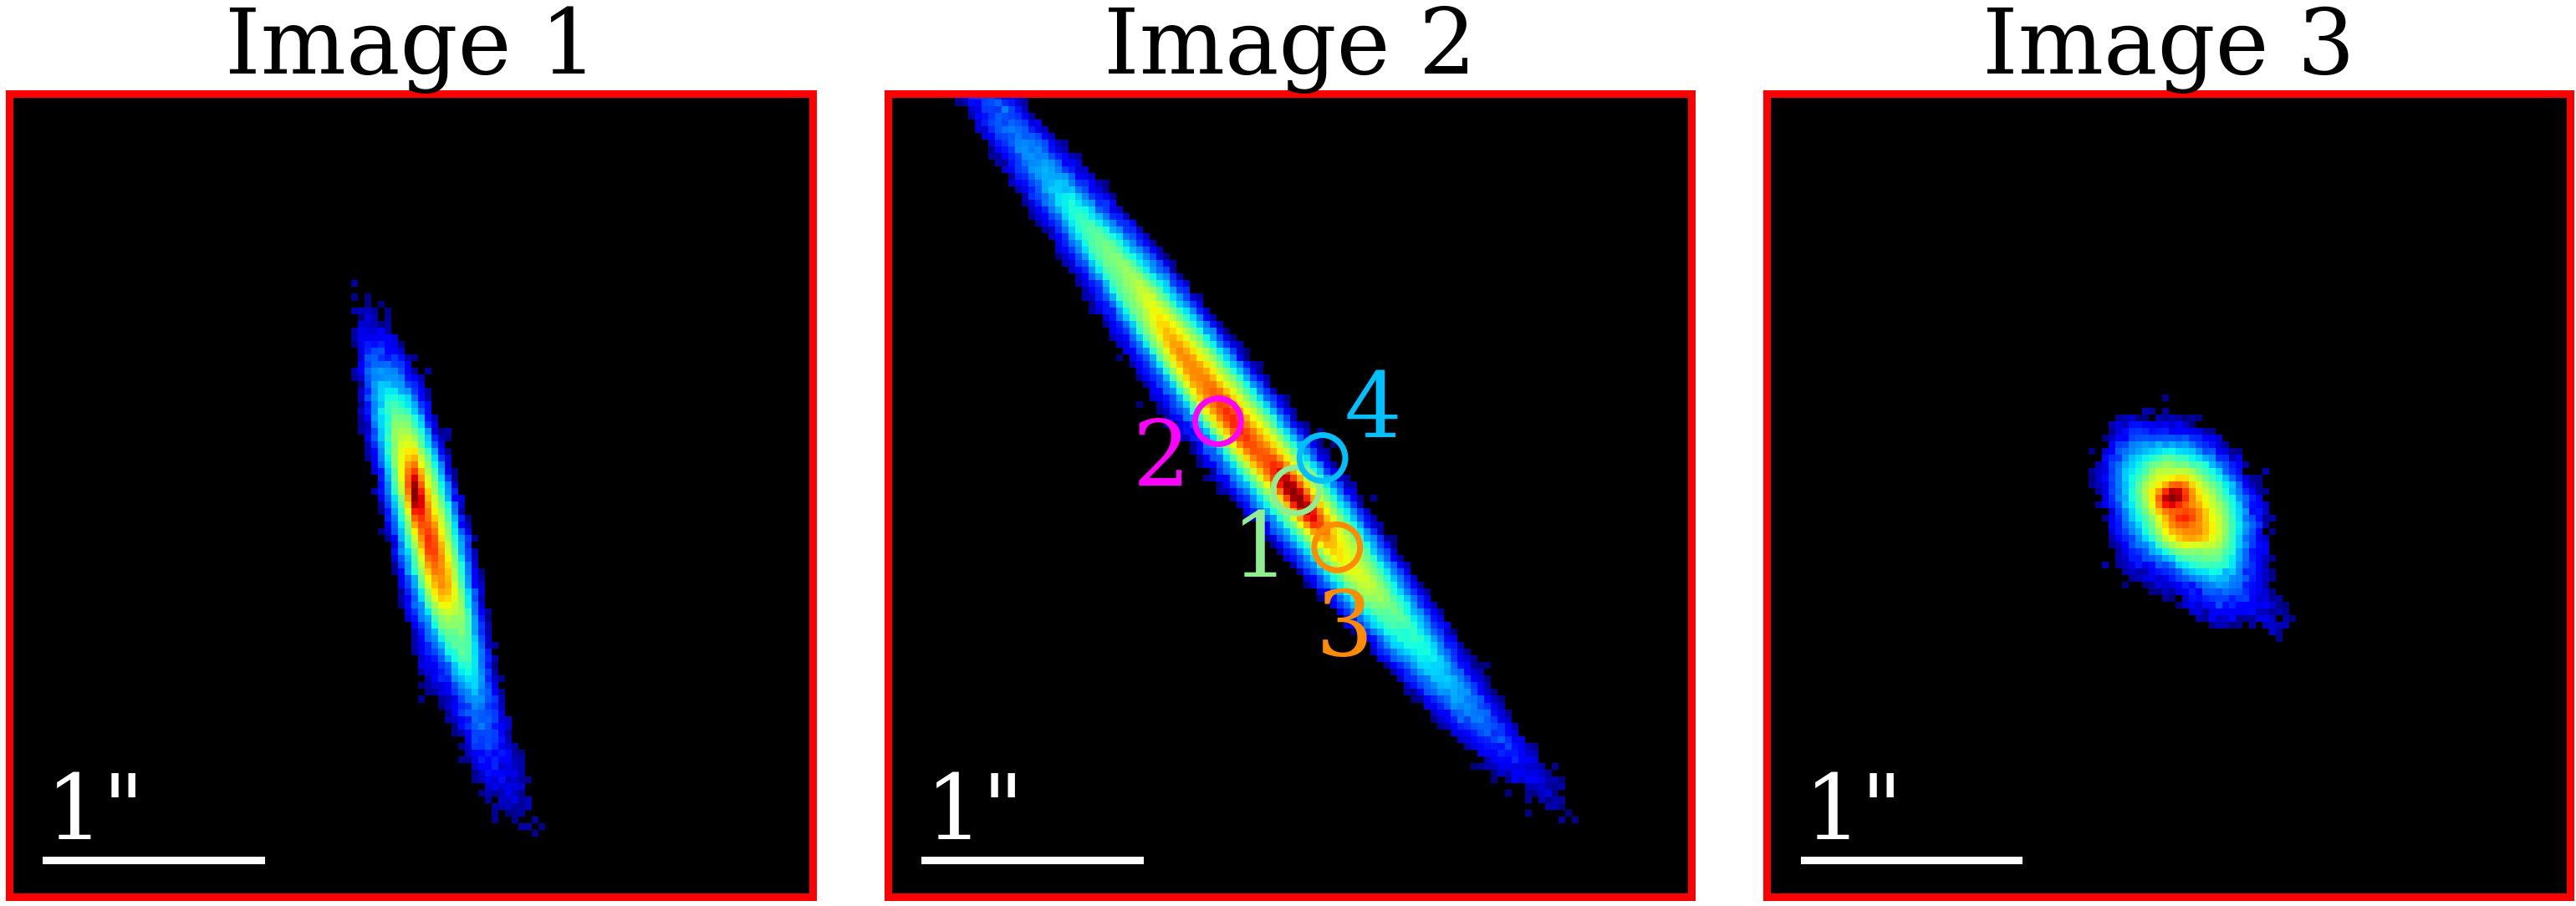

In [5]:
import matplotlib.lines as lines
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

ext = numPix2*deltaPix*0.5

extent = [-ext,ext,-ext,ext]

scal = 3.

f, axes = plt.subplots(1, 3, figsize=(15*scal,15*scal))
ax = axes

fontsss = 36

txtclr = 'Black'

vmin = np.nanmax(np.log10(mockimagesA[0]))-1.5
vmax = np.nanmax(np.log10(mockimagesA[0]))


ax[0].set_title('Image 1',fontsize = fontsss*scal, color=txtclr)
ax[1].set_title('Image 2',fontsize = fontsss*scal, color=txtclr)
ax[2].set_title('Image 3',fontsize = fontsss*scal, color=txtclr)

im0 = ax[0].imshow(np.log10(mockimages2A[2]*likemask), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
im0 = ax[1].imshow(np.log10(mockimages2A[1]*likemask2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
im0 = ax[2].imshow(np.log10(mockimages2A[0]*likemask3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)

ax[1].scatter(xpp1,ypp1, s=3000,linewidth=7,marker='o',facecolors='none',edgecolor='lightgreen')
ax[1].scatter(xpp2,ypp2, s=3000,linewidth=7,marker='o',facecolors='none',edgecolor='magenta')
ax[1].scatter(xpp3,ypp3, s=3000,linewidth=7,marker='o',facecolors='none',edgecolor='darkorange')
ax[1].scatter(xpp4,ypp4, s=3000,linewidth=7,marker='o',facecolors='none',edgecolor='deepskyblue')


ax[1].text(xpp1-0.3,ypp1-0.4,'1', fontsize = fontsss*scal,color='lightgreen')
ax[1].text(xpp2-0.4,ypp2-0.3,'2', fontsize = fontsss*scal,color='magenta')
ax[1].text(xpp3-0.1,ypp3-0.5,'3', fontsize = fontsss*scal,color='darkorange')
ax[1].text(xpp4+0.1,ypp4+0.1,'4', fontsize = fontsss*scal,color='deepskyblue')

for axk in ax:
    axk.set_xticklabels([])
    axk.set_yticklabels([])

    axk.set_xticks([])
    axk.set_yticks([])

    for direc in ['left', 'right', 'top', 'bottom']:

        axk.spines[direc].set_color('red') 
        axk.spines[direc].set_linewidth(3*scal)

x1 = [-1.7,-1.7+1.]
y1 = [-1.7,-1.7]

ax[0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[0].text(-1.7,-1.6, '1"', fontsize = fontsss*scal,color='White')

ax[1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[1].text(-1.7,-1.6, '1"', fontsize = fontsss*scal,color='White')

ax[2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[2].text(-1.7,-1.6, '1"', fontsize = fontsss*scal,color='White')        
        
plt.tight_layout()
plt.show()

In [6]:
dresultsA = load_obj('../smacs_0723/lowcPOSA_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresultsB = load_obj('../smacs_0723/lowcPOSB_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresultsC = load_obj('../smacs_0723/lowcPOSC_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresultsD = load_obj('../smacs_0723/lowcPOSD_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')

In [7]:
maxlA, bestfA, cvA = bestfit(dresultsA)
maxlB, bestfB, cvB = bestfit(dresultsB)
maxlC, bestfC, cvC = bestfit(dresultsC)
maxlD, bestfD, cvD = bestfit(dresultsD)

In [8]:
labls_mask = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{8}$ [$M_\odot$]', '$c_{200}$', '$x_p$' , '$x_p$']

pip install dynesty==2.1.0

4
(0.0, 0.1836503182786378)
(0.0, 0.15969036357747857)
(0.0, 17.621946977463352)
(0.0, 16.45169504557963)


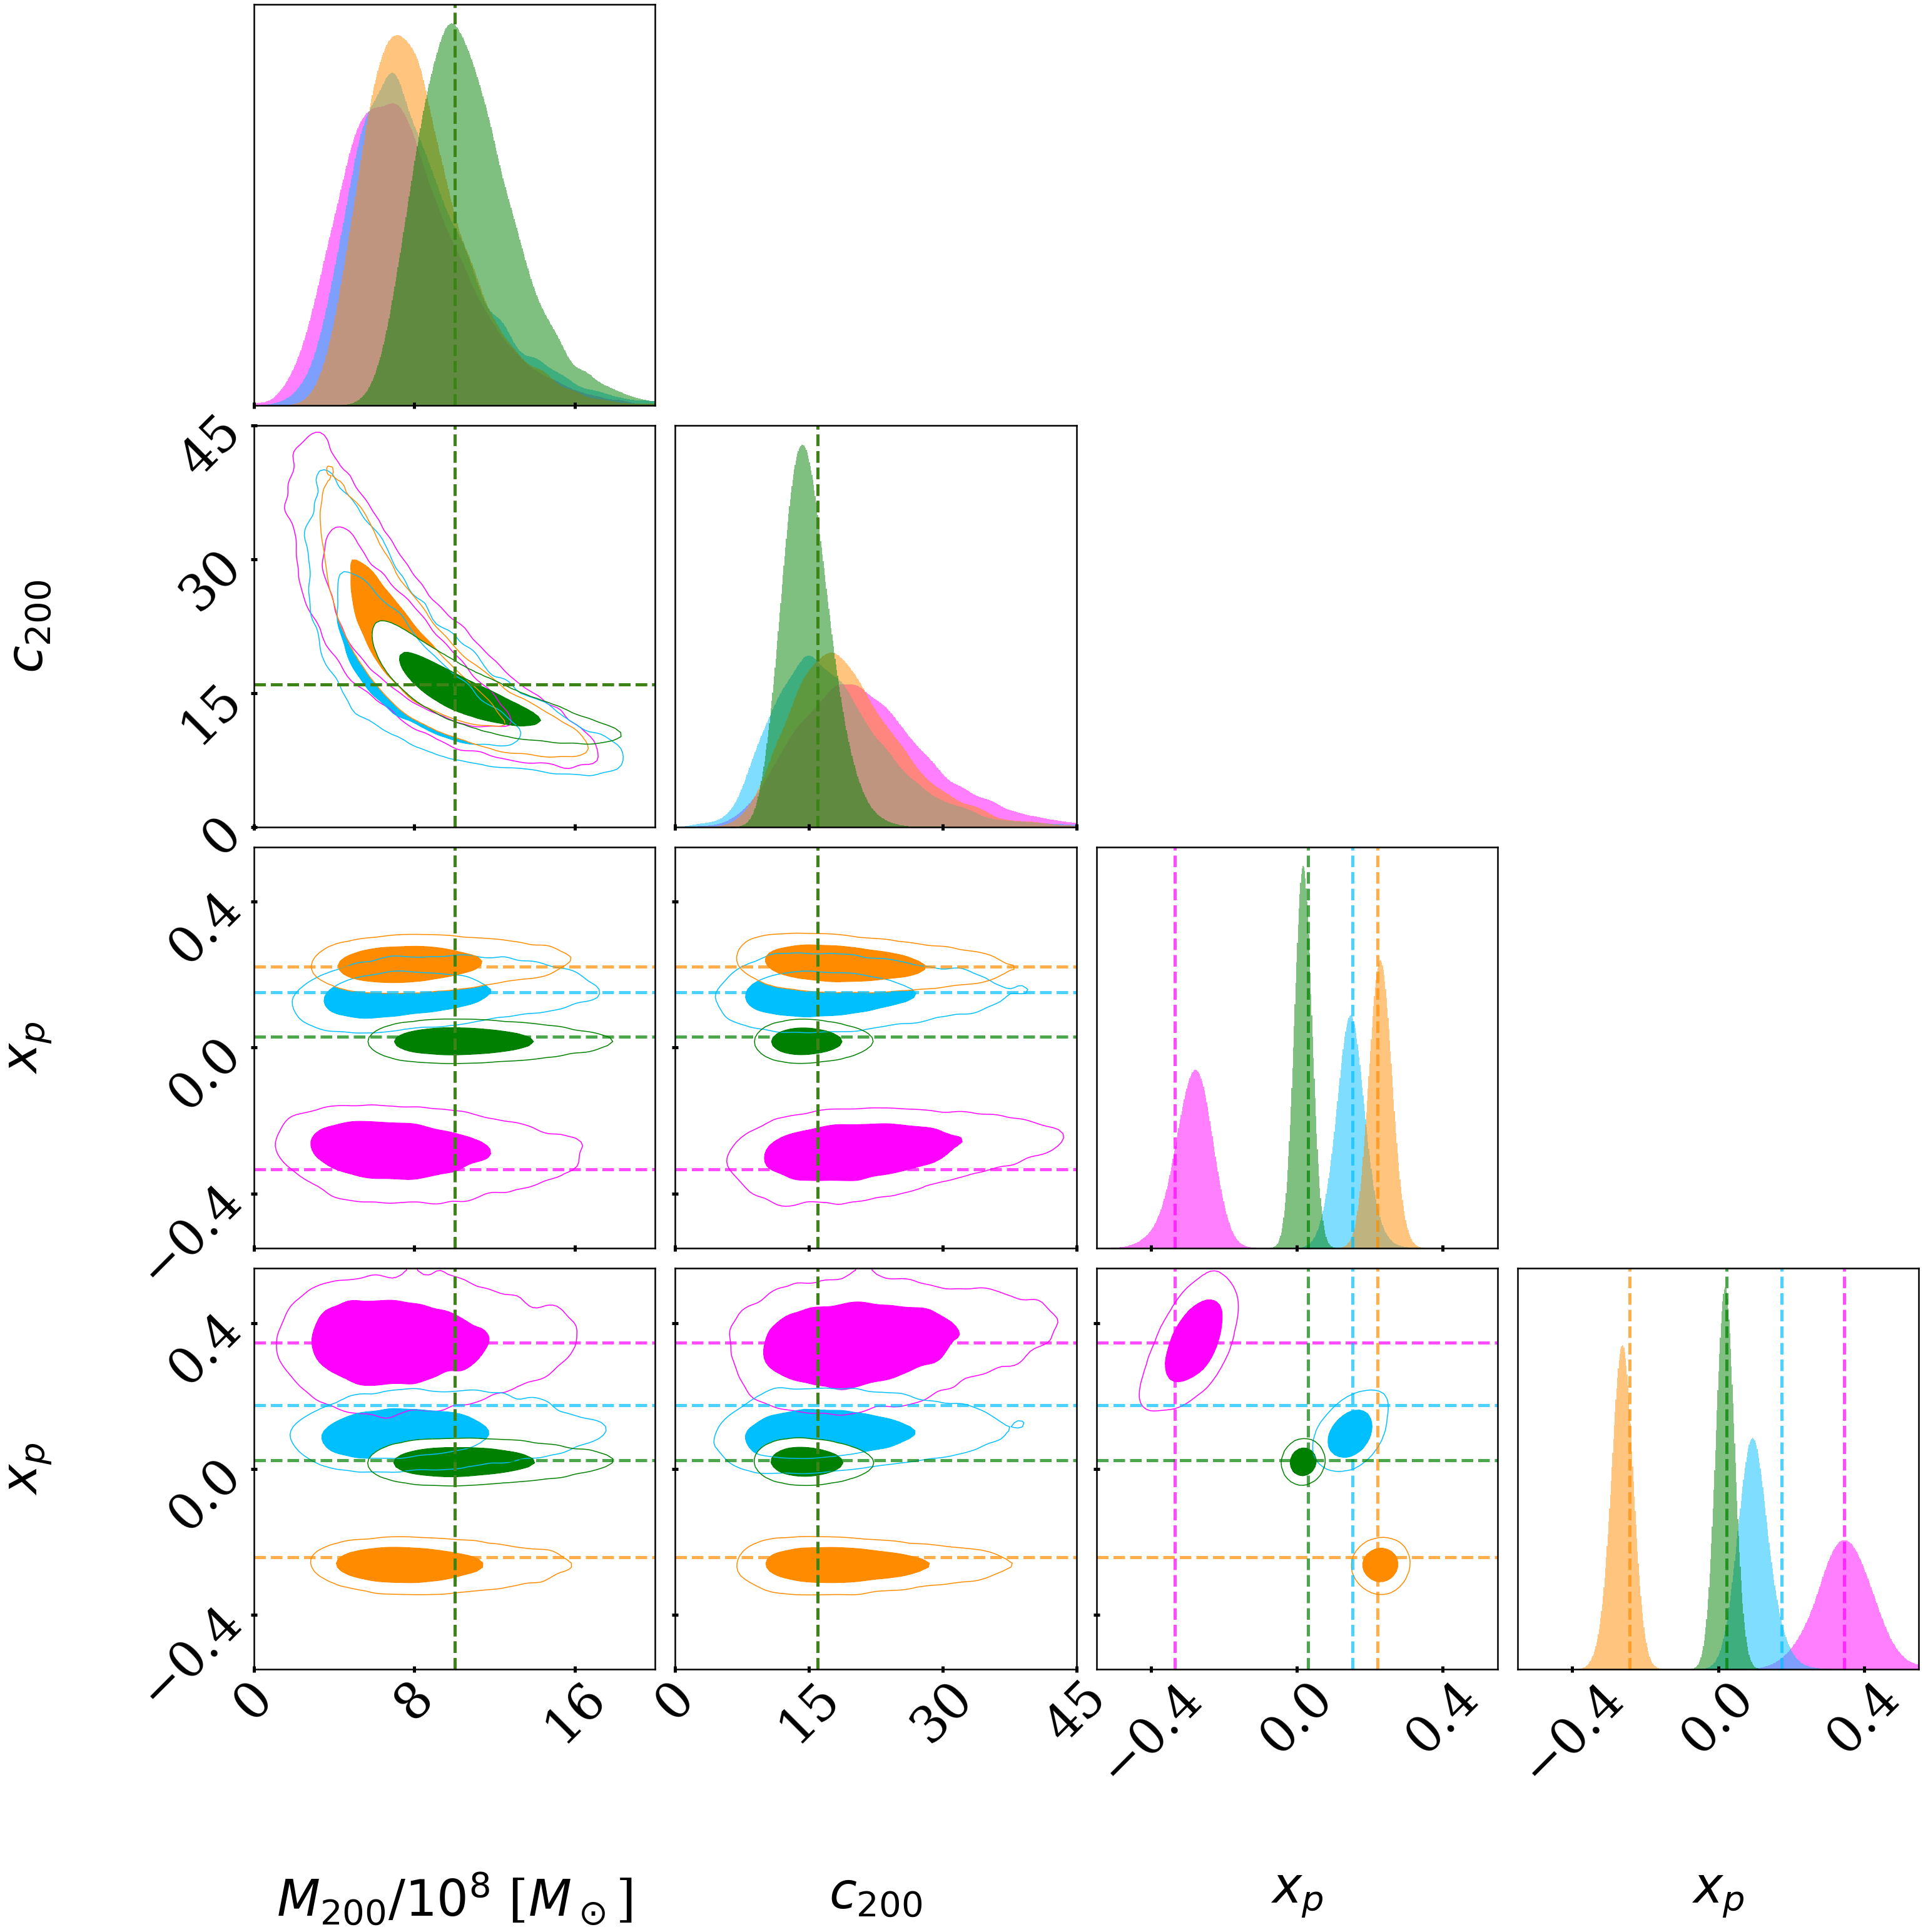

In [9]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 4

nlist = np.array(np.concatenate([np.arange(21,25)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask[nlist[i]])
    bestfpp[i] = bestfA[nlist[i]]

bestftrue1 = np.array([10.,16.,xpp1,ypp1])
bestftrue2 = np.array([10.,16.,xpp2,ypp2])
bestftrue3 = np.array([10.,16.,xpp3,ypp3])
bestftrue4 = np.array([10.,16.,xpp4,ypp4])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.2)*N,9*(1.2)*N))

span = [[0.,20.],[0.,45.],[-0.55,0.55],[-0.55,0.55]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot1,intcbestplot1 = dresultsA, bestftrue1
intcplot2,intcbestplot2 = dresultsB, bestftrue2
intcplot3,intcbestplot3 = dresultsC, bestftrue3
intcplot4,intcbestplot4 = dresultsD, bestftrue4


tfig1, taxes1 = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='magenta',labels=None,color='magenta',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic)


tfig2k, taxes2k = dyplot.cornerplot(intcplot4,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot4,truth_color='deepskyblue',labels=None,color='deepskyblue',fig=[tfig1, taxes1],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig20, taxes20 = dyplot.cornerplot(intcplot3,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot3,truth_color='darkorange',labels=None,color='darkorange',fig=[tfig2k, taxes2k],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2, taxes2 = dyplot.cornerplot(intcplot1,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot1,truth_color='green',labels=None,color='green',fig=[tfig20, taxes20],
                                  hist_kwargs=histdic,truth_kwargs=truedic)


for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()

# Core radius test

In [10]:
dresults_core = load_obj('../smacs_0723/NOPSF_with_1e9_16_core03_PERTURBED_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')

labls_mask_core = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{8}$ [$M_\odot$]', '$c_{200}$', '$c$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']

maxl_core, bestf_core, cv_core = bestfit(dresults_core)

5


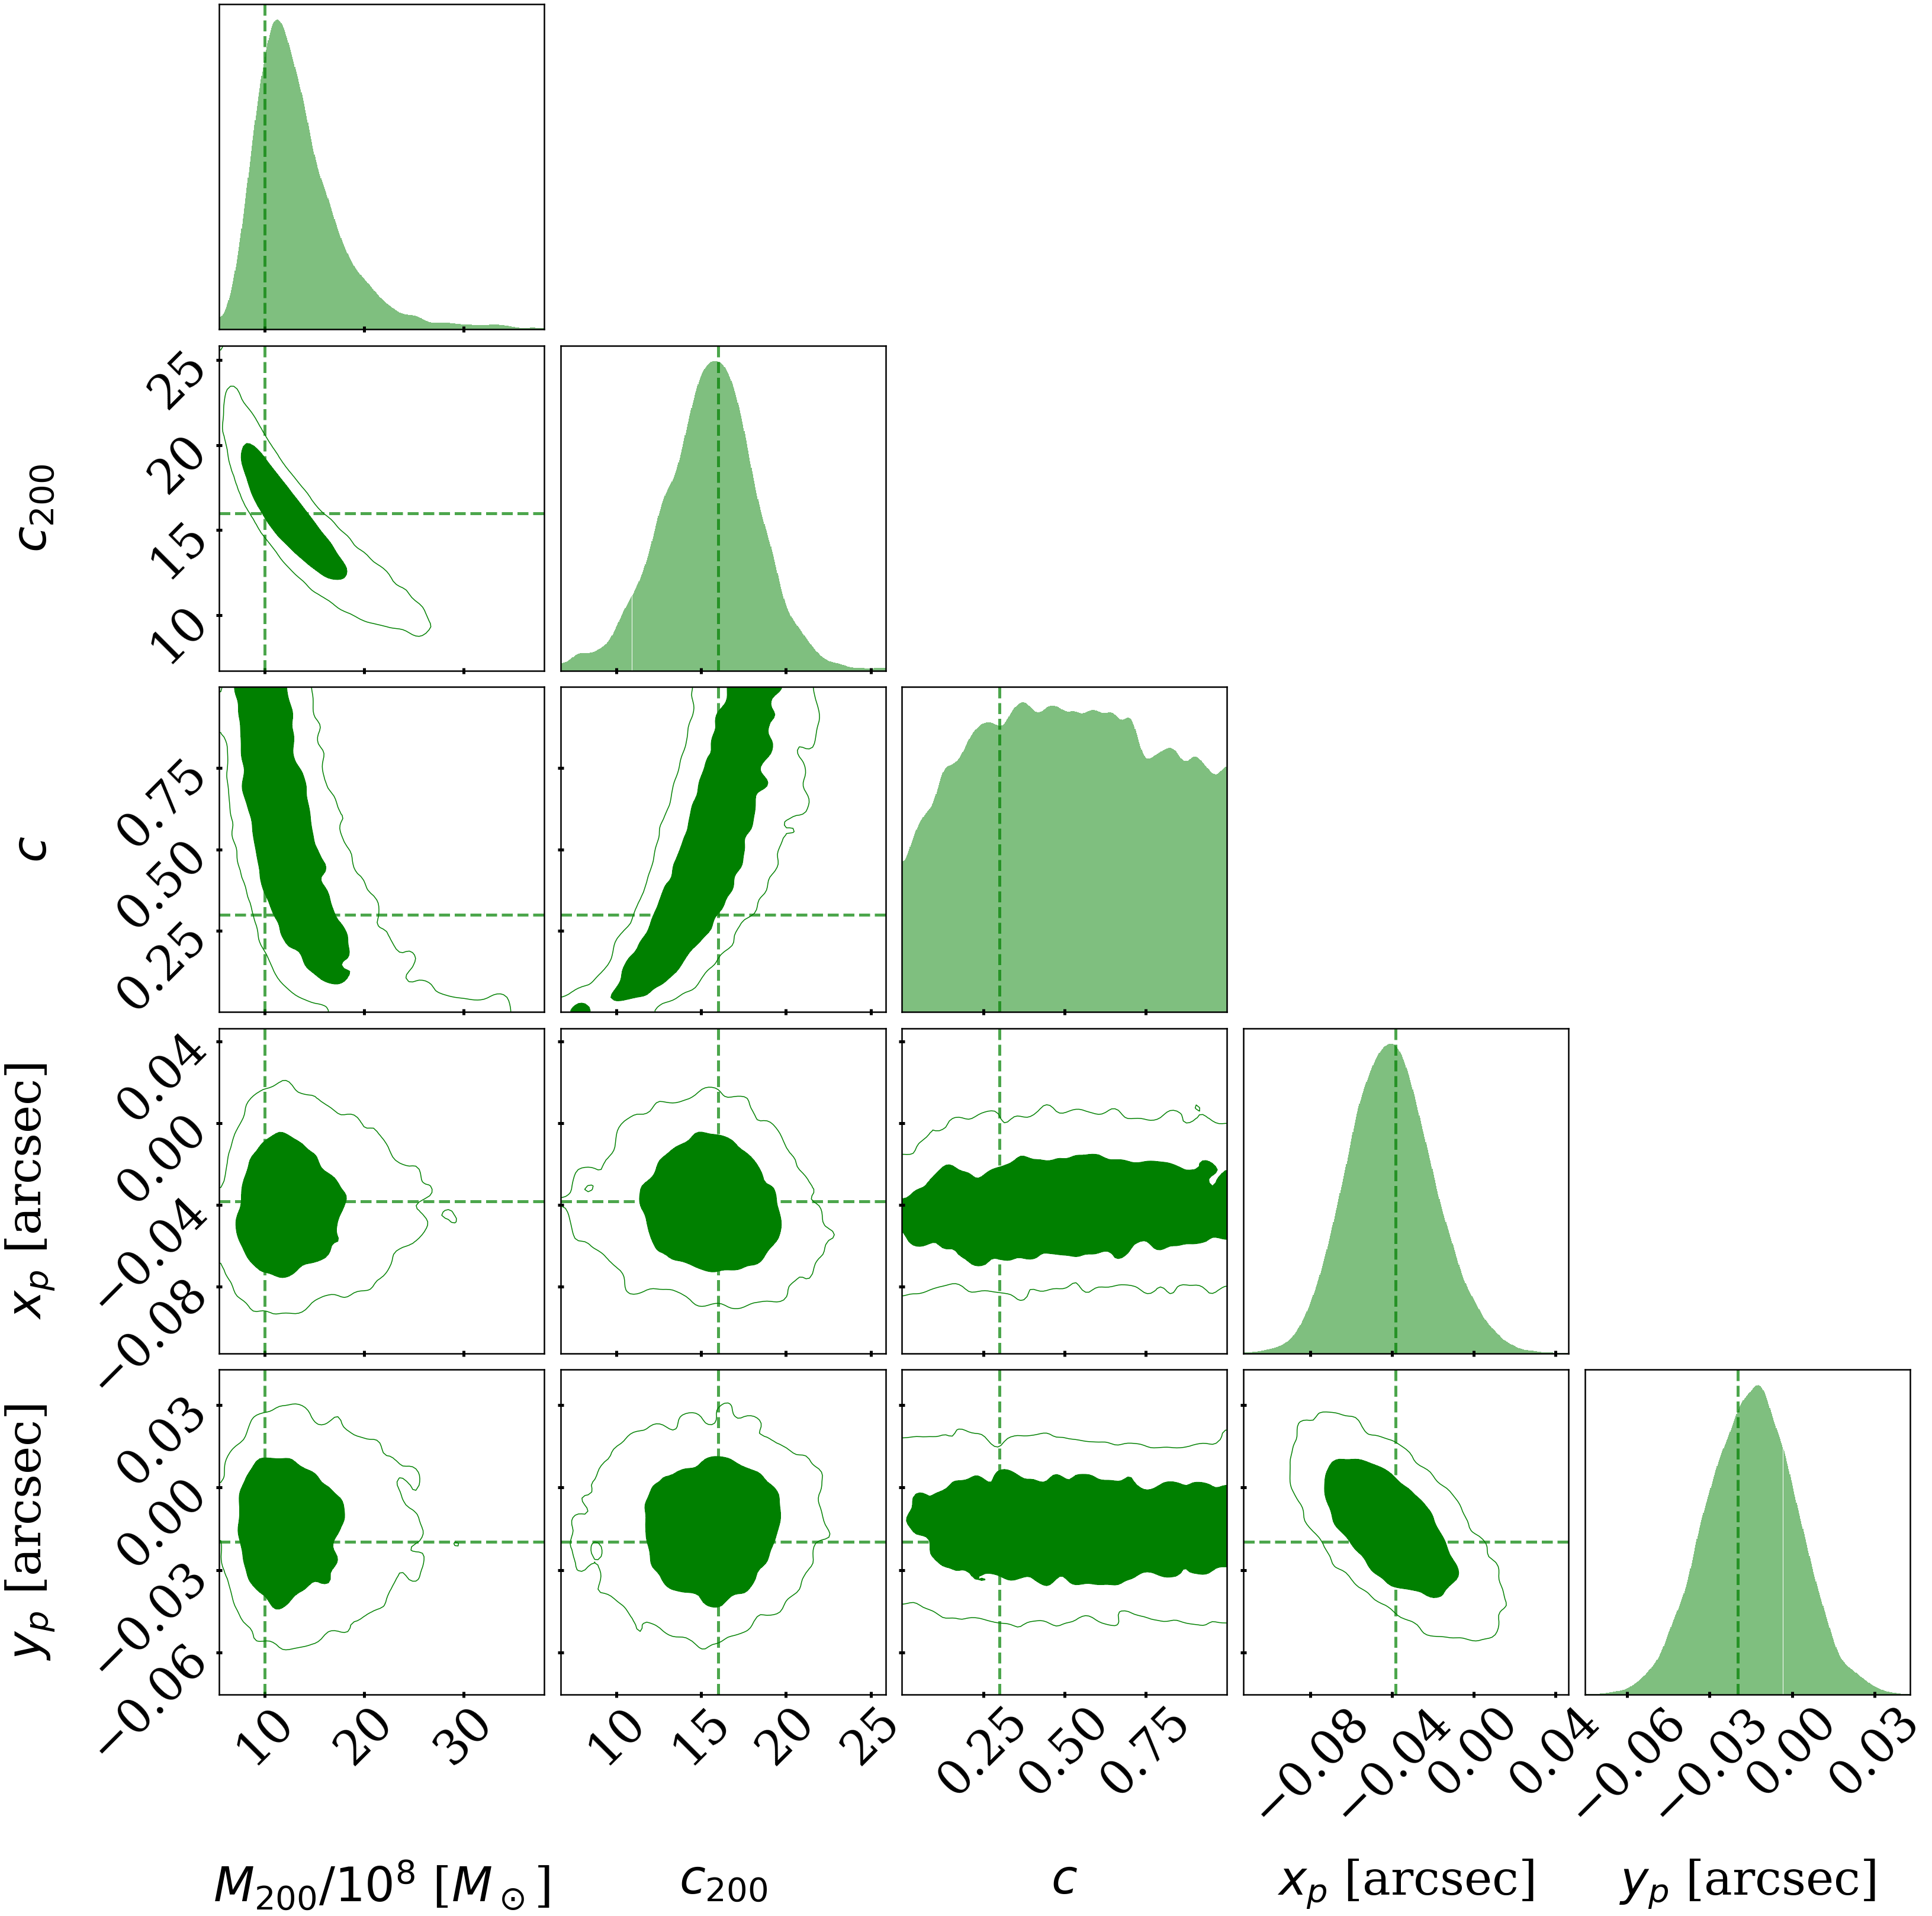

In [11]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}
hist2dic = {'no_fill_contours':True,
            'fill_contours':False,
            'plot_density':False}
hist2dic2 = {}

N = 5

nlist = np.array(np.concatenate([np.arange(21,26)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_core[nlist[i]])
    bestfpp[i] = bestf_core[nlist[i]]

bestftrue = np.array([10.,16.,0.3, -0.0382764,-0.01969881])
tfig2,taxes2 = plt.subplots(N,N,figsize=(9*N,9*N))

span = np.ones(N)*0.9995#[[0.5,5.0],[0.,120.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot,intcbestplot = dresults_core, bestftrue

tfig2, _ = dyplot.cornerplot(intcplot,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot,truth_color='green',labels=None,color='green',fig=[tfig2, taxes2],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
#plt.tight_layout()
plt.show()

# Ellipticity Test

In [12]:
dresults_ellip = load_obj('../smacs_0723/NOPSFwid_with_1e9_16_ellip0302_PERTURBED_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')

labls_mask_ellip = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{8}$ [$M_\odot$]', '$c_{200}$', '$e_1$','$e_2$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']

maxl_ellip, bestf_ellip, cv_ellip = bestfit(dresults_ellip)

6


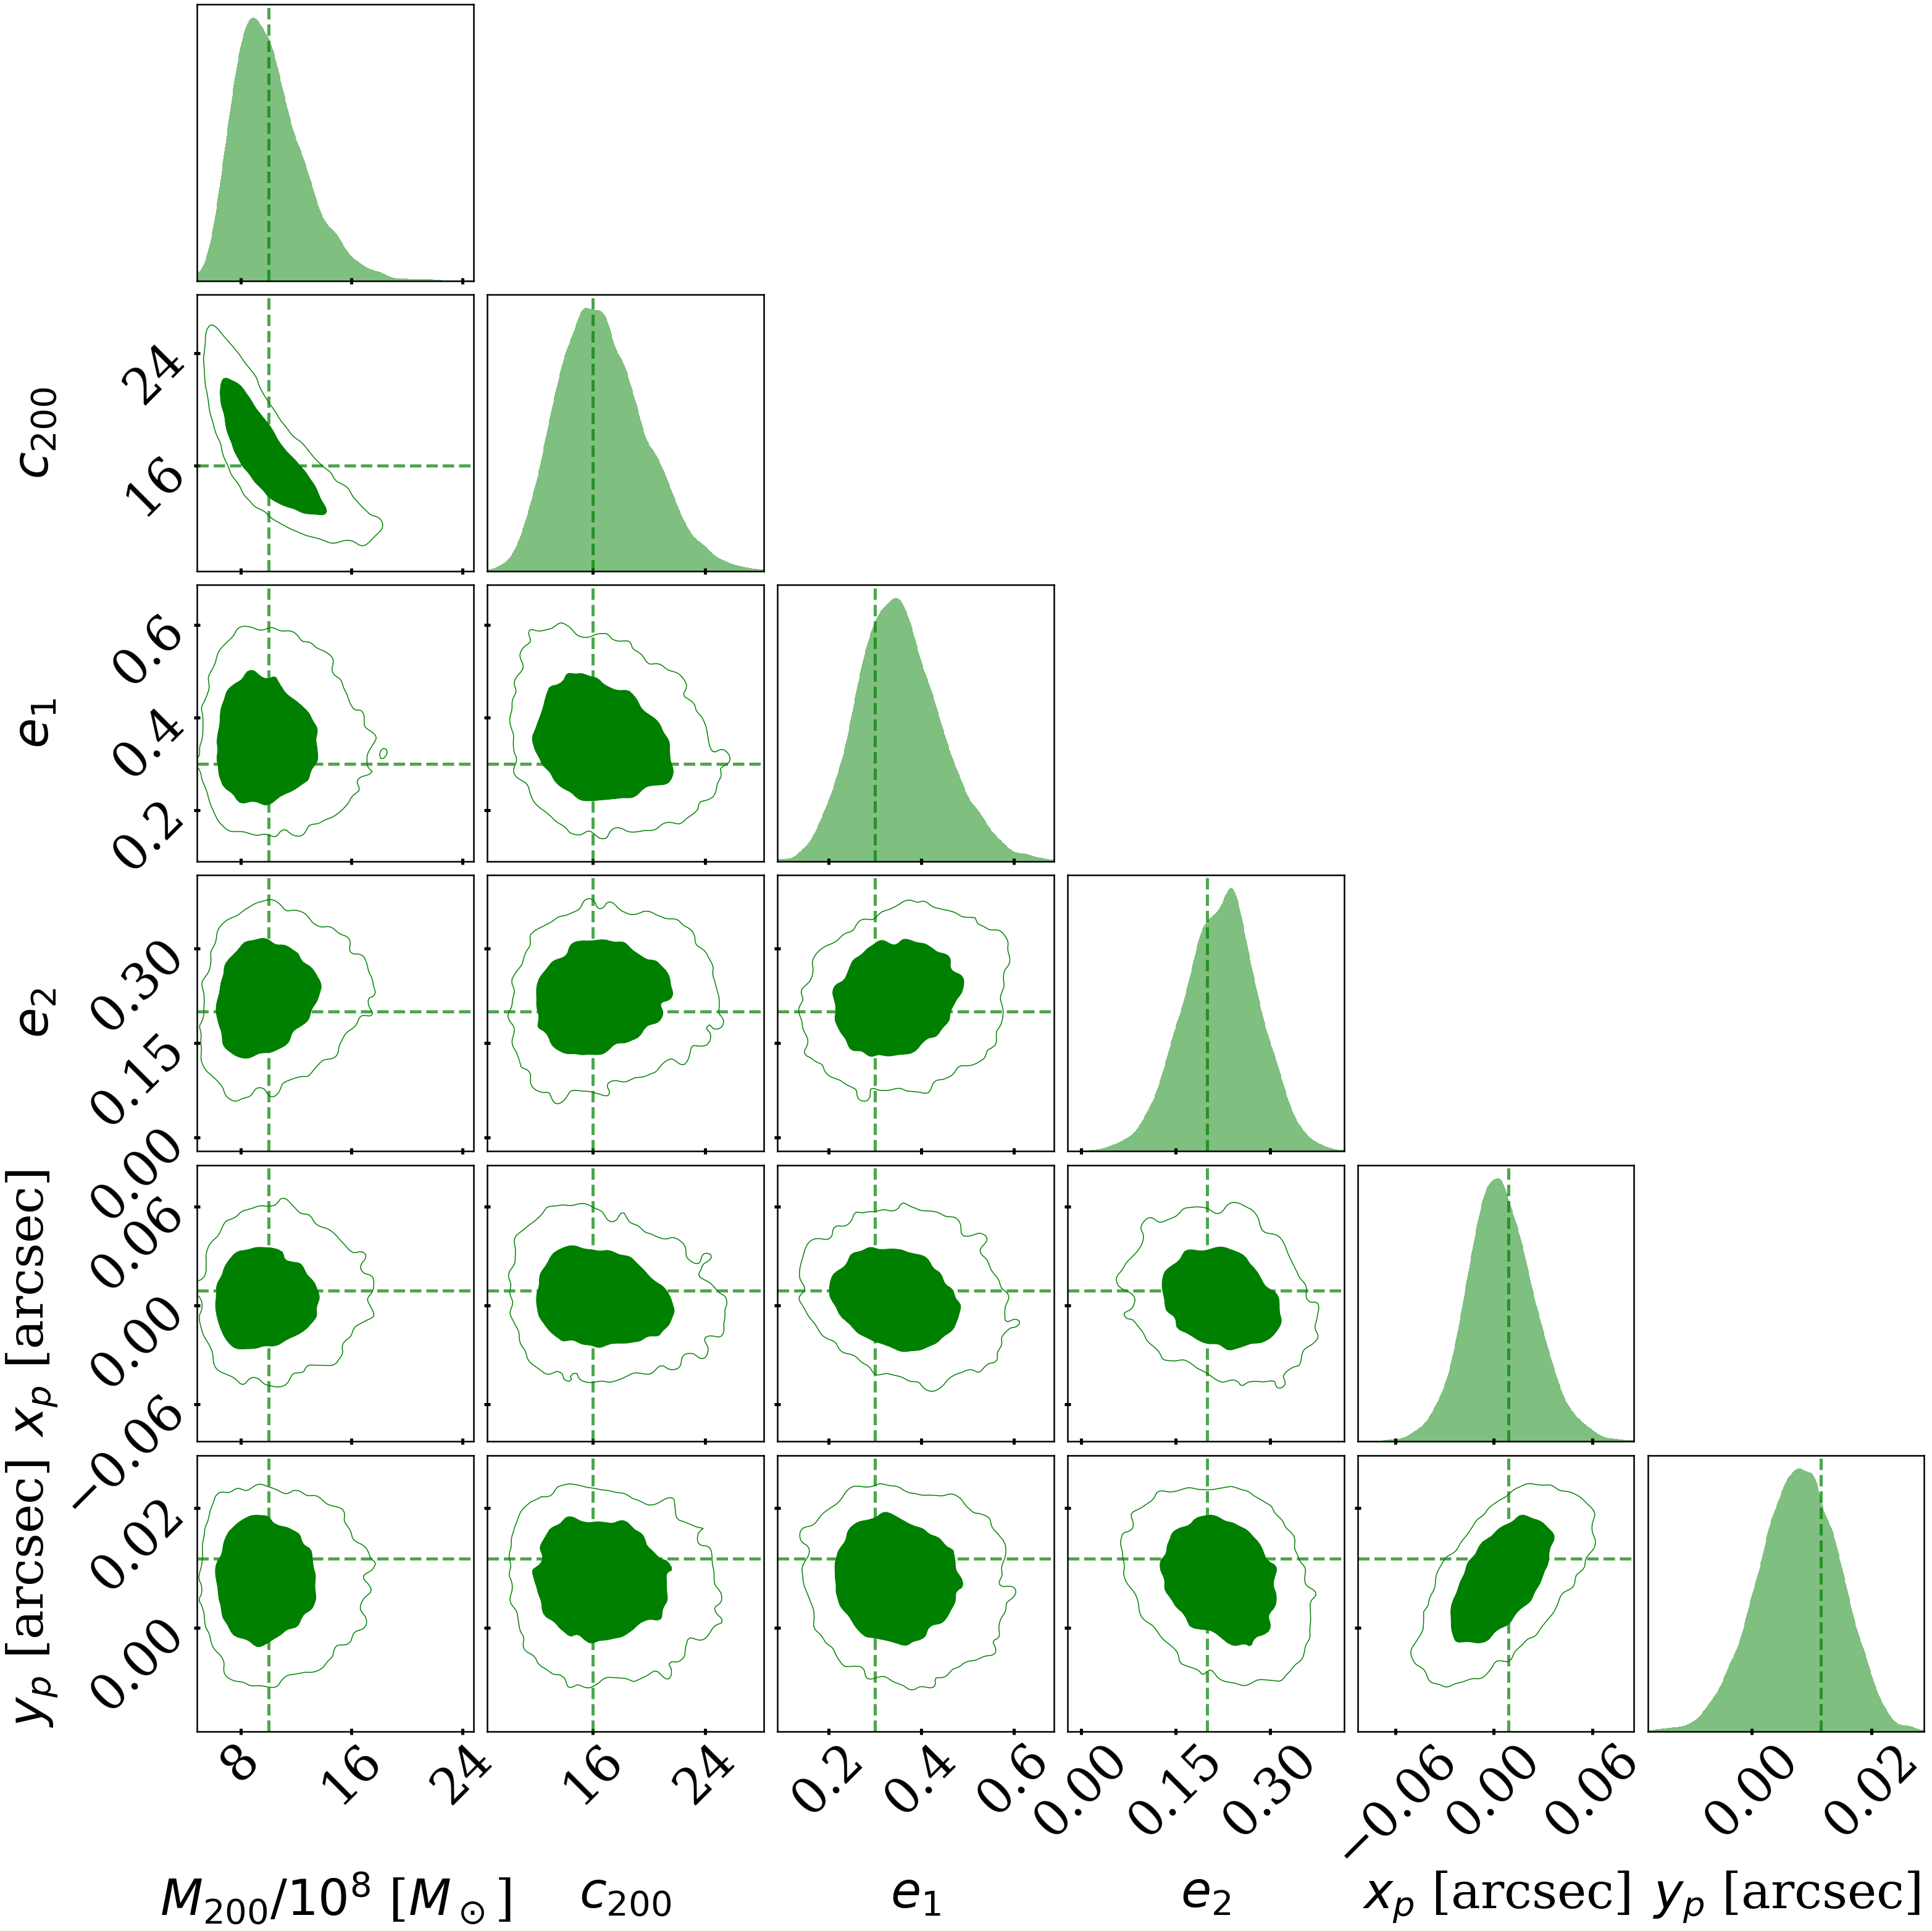

In [13]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 6

nlist = np.array(np.concatenate([np.arange(21,27)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_ellip[nlist[i]])
    bestfpp[i] = bestf_ellip[nlist[i]]

bestftrue = np.array([10.,16.,0.3,0.2, 0.0089934685,0.0115336])
tfig2,taxes2 = plt.subplots(N,N,figsize=(9*(0.8)*N,9*(0.8)*N))

span = np.ones(N)*0.9995#[[0.5,5.0],[0.,120.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot,intcbestplot = dresults_ellip, bestftrue

tfig2, _ = dyplot.cornerplot(intcplot,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot,truth_color='green',labels=None,color='green',fig=[tfig2, taxes2],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
plt.show()

# Redshift Tests

In [14]:
dresults_z1 = load_obj('../smacs_0723/NOPSF_with_1e9_16_PERTURBED_zint=02_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')
dresults_z2 = load_obj('../smacs_0723/NOPSF_with_1e9_16_PERTURBED_zint=03877_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')
dresults_z3 = load_obj('../smacs_0723/NOPSF_with_1e9_16_PERTURBED_zint=05_FIXmur=1_3_images_chunk1SHAPE_SHAPEnmax18nmax28')


labls_mask_z2 = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{8}$ [$M_\odot$]', '$c_{200}$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]', 'Redshift']

maxl_z1, bestf_z1, cv_z1 = bestfit(dresults_z1)
maxl_z2, bestf_z2, cv_z2 = bestfit(dresults_z2)
maxl_z3, bestf_z3, cv_z3 = bestfit(dresults_z3)

5
(0.0, 0.3027117065854957)
(0.0, 0.059652216836957296)
(0.0, 61.94131010535474)
(0.0, 84.44415419894784)
(0.0, 12.715669240681525)


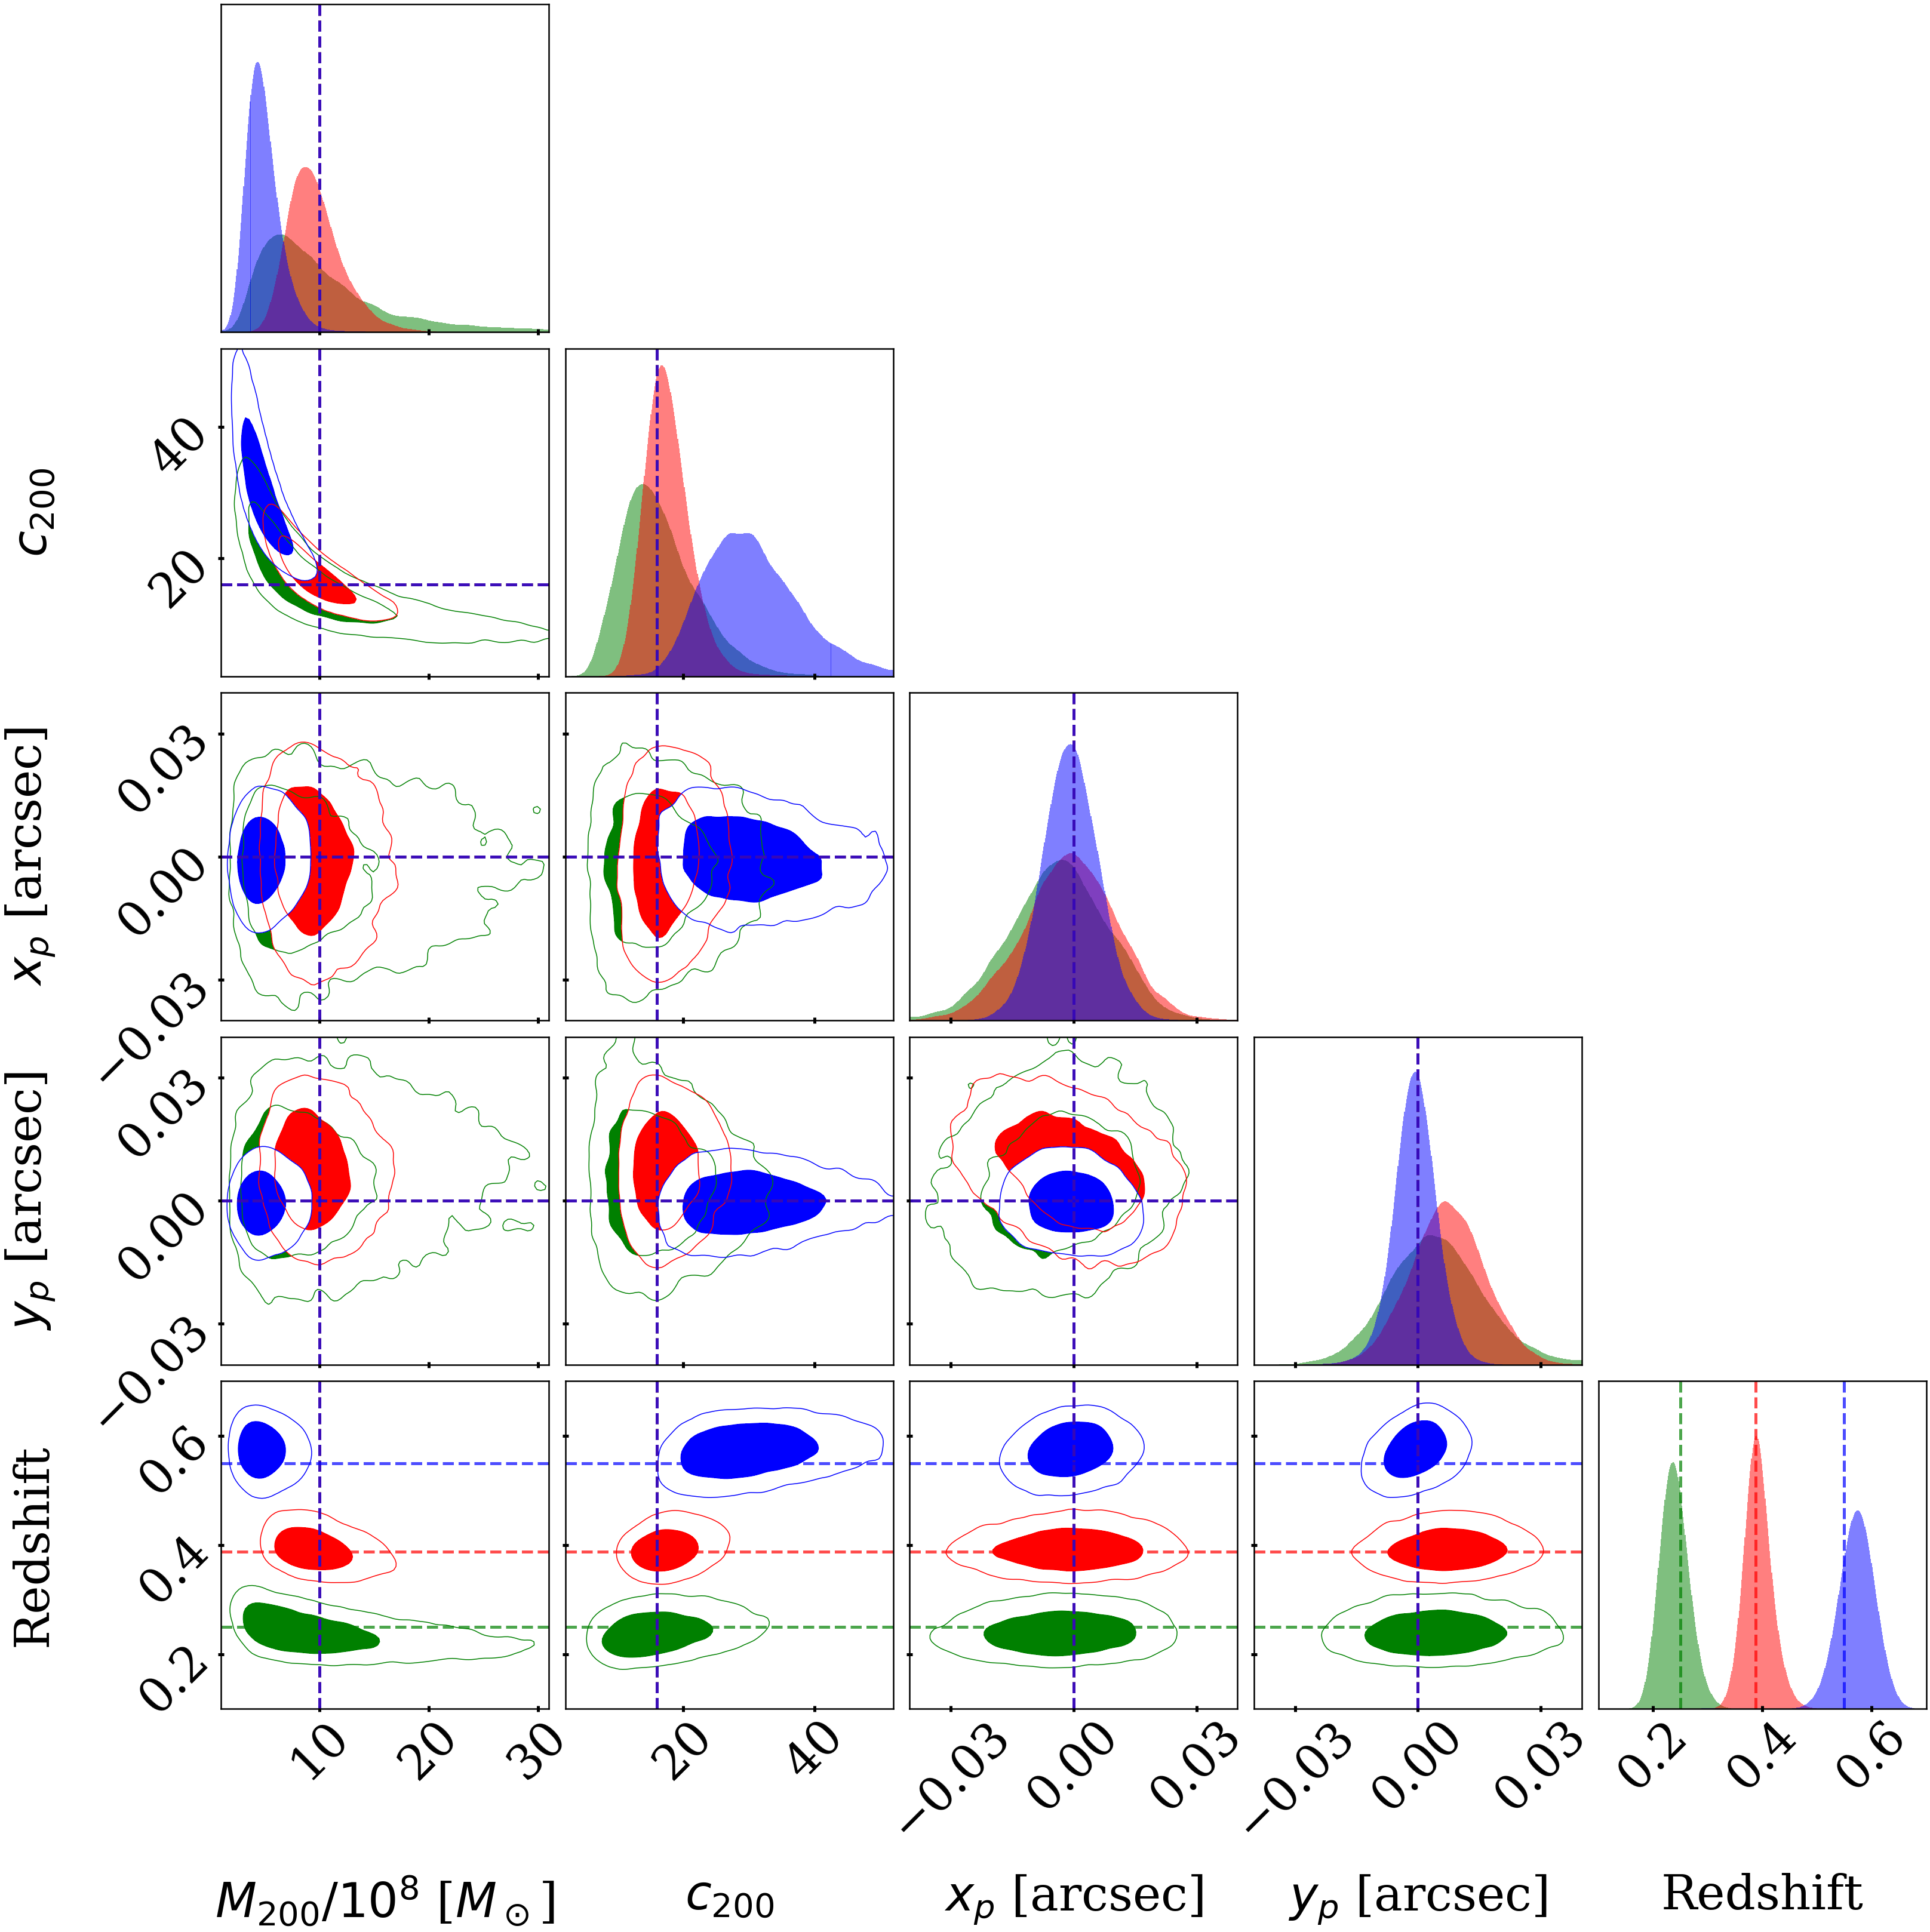

In [15]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 5

nlist = np.array(np.concatenate([np.arange(21,26)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_z2[nlist[i]])
    bestfpp[i] = bestf_z2[nlist[i]]

bestftrue1 = np.array([10.,16.,0.,0.,0.25])
bestftrue2 = np.array([10.,16.,0.,0.,0.3877])
bestftrue3 = np.array([10.,16.,0.,0.,0.55])

tfig_,taxes_= plt.subplots(N,N,figsize=(9*N,9*N))

span = [[1.,31.],[2.,52.],[-0.04,0.04],[-0.04,0.04],[0.1,0.7]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot1,intcbestplot1 = dresults_z1, bestftrue1
intcplot2,intcbestplot2 = dresults_z2, bestftrue2
intcplot3,intcbestplot3 = dresults_z3, bestftrue3


tfig0, taxes0 = dyplot.cornerplot(intcplot1,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot1,truth_color='green',labels=None,color='green',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig1, taxes1 = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='red',labels=None,color='red',fig=[tfig0, taxes0],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2, taxes2 = dyplot.cornerplot(intcplot3,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot3,truth_color='blue',labels=None,color='blue',fig=[tfig1, taxes1],
                                  hist_kwargs=histdic,truth_kwargs=truedic)


for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
taxes2[0,0].set_ylim(0.0, 0.35)
taxes2[1,1].set_ylim(0.0, 0.13)
taxes2[2,2].set_ylim(0.0, 70.)
taxes2[3,3].set_ylim(0.0, 90.)
taxes2[4,4].set_ylim(0.0, 20.)
plt.show()

# Mass Sensitivity

In [16]:
dresults90 = load_obj('../smacs_0723/lowcPOSA_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults85 = load_obj('../smacs_0723/lowcPOSA_with_10_85_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults80 = load_obj('../smacs_0723/lowcPOSA_with_10_80_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults75 = load_obj('../smacs_0723/lowcPOSA_with_10_75_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults70 = load_obj('../smacs_0723/lowcPOSA_with_10_70_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')


dresults90.samples[:,21] = dresults90.samples[:,21]/10.
dresults80.samples[:,21] = dresults80.samples[:,21]/10.

labls_mask_mass = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/M_\mathrm{true}$', '$c_{200}$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']





maxl_90, bestf_90, cv_90 = bestfit(dresults90)
maxl_85, bestf_85, cv_85 = bestfit(dresults85)
maxl_80, bestf_80, cv_80 = bestfit(dresults80)
maxl_75, bestf_75, cv_75 = bestfit(dresults75)
maxl_70, bestf_70, cv_70 = bestfit(dresults70)

4
(0.0, 1.6759891617042861)
(0.0, 0.1574041458085362)
(0.0, 41.778101193479735)
(0.0, 30.282090563716203)


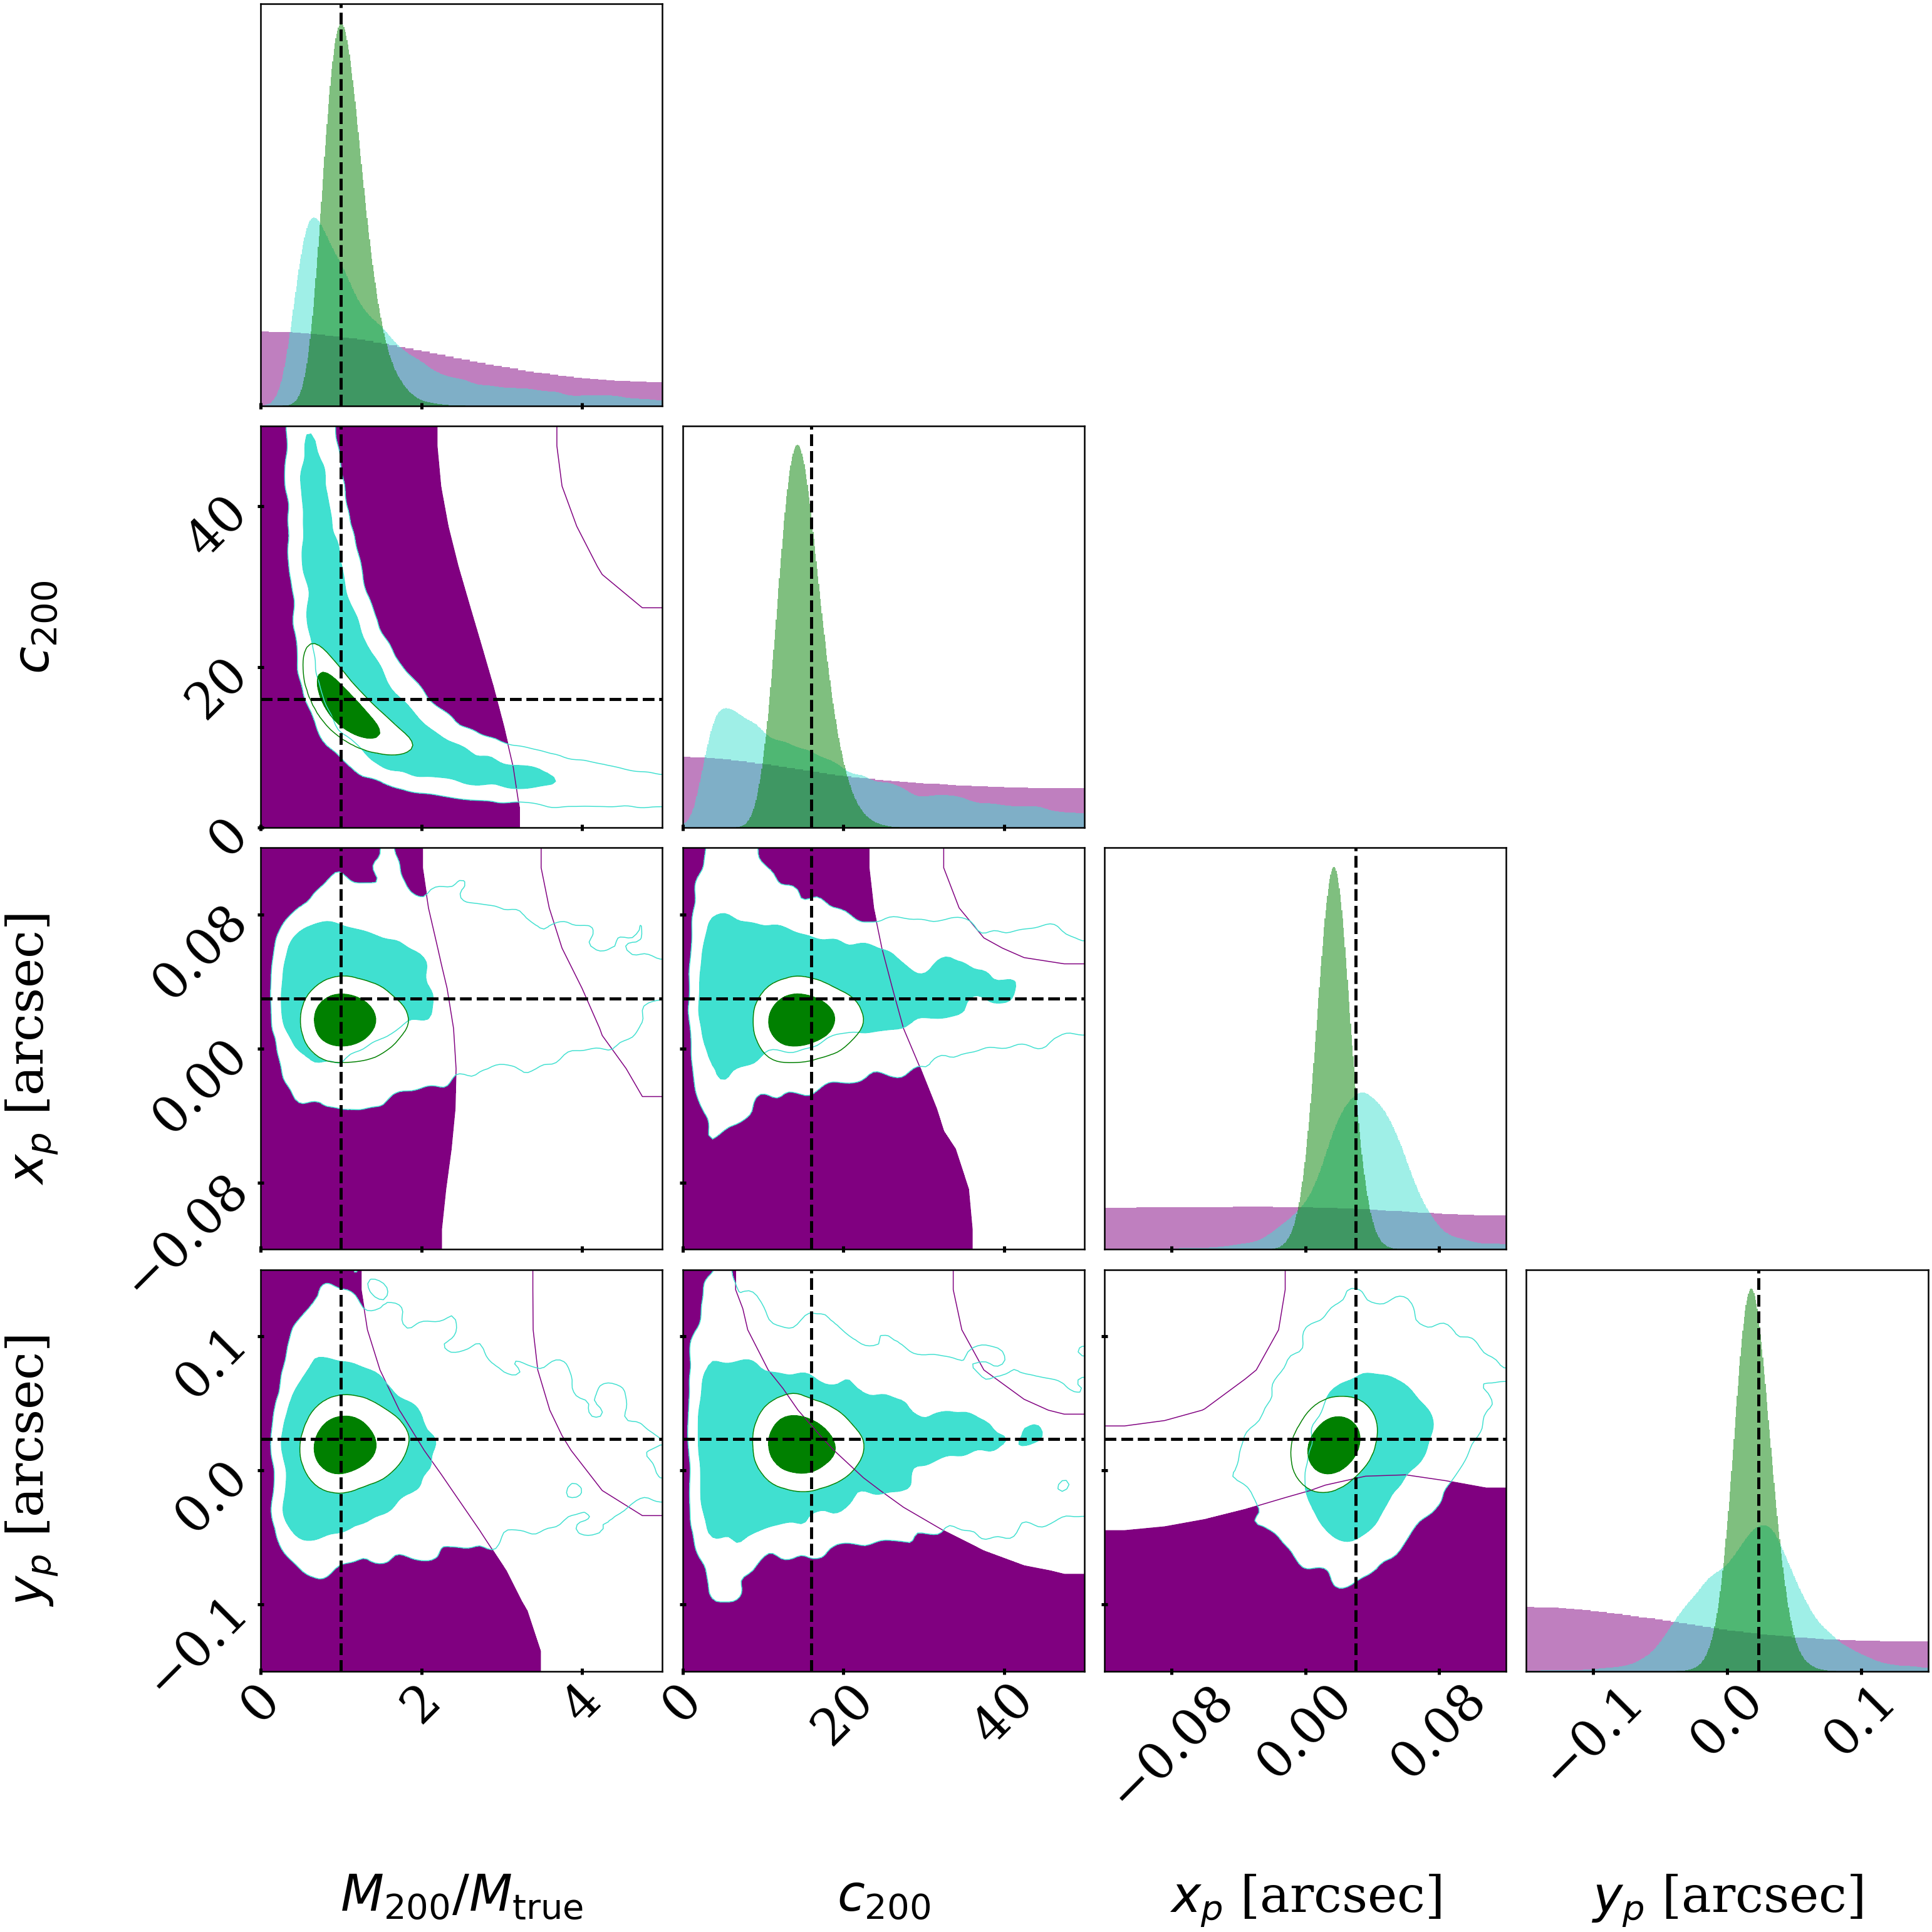

In [17]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}


N = 4

nlist = np.array(np.concatenate([np.arange(21,25)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_mass[nlist[i]])
    bestfpp[i] = bestfA[nlist[i]]

bestftrue0 = np.array([1.,16.,xpp1,ypp1])
bestftrue1 = np.array([1.,16.,xpp1,ypp1])
bestftrue2 = np.array([1.,16.,xpp1,ypp1])
bestftrue3 = np.array([1.,16.,xpp1,ypp1])
bestftrue4 = np.array([1.,16.,xpp1,ypp1])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.2)*N,9*(1.2)*N))

span = [[0.,5.],[0.,50.],[-0.12,0.12],[-0.15,0.15]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot5,intcbestplot5 = dresults90, bestftrue0
#intcplot1,intcbestplot1 = dresults85, bestftrue1
intcplot4,intcbestplot4 = dresults80, bestftrue2
#intcplot3,intcbestplot3 = dresults75, bestftrue3
intcplot2,intcbestplot2 = dresults70, bestftrue4




#tfig1, taxes1 = dyplot.cornerplot(intcplot1,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot1,truth_color='magenta',labels=None,color='magenta',fig=[tfig_, taxes_],
#                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2k, taxes2k = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='black',labels=None,color='purple',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic,smooth=0.2)

#tfig20, taxes20 = dyplot.cornerplot(intcplot3,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot3,truth_color='darkorange',labels=None,color='darkorange',fig=[tfig2k, taxes2k],
#                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2u, taxes2u = dyplot.cornerplot(intcplot4,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot4,truth_color='black',labels=None,color='turquoise',fig=[tfig2k, taxes2k],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2, taxes2 = dyplot.cornerplot(intcplot5,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot5,truth_color='black',labels=None,color='green',fig=[tfig2u, taxes2u],
                                  hist_kwargs=histdic,truth_kwargs=truedic)


for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()

In [18]:
dresults70 = load_obj('../smacs_0723/times03_4_times05_9_lowcPOSA_with_10_90_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults90 = load_obj('../smacs_0723/lowcPOSA_with_1e9_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')


labls_mask_mass = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{8}$ [$M_\odot$]', '$c_{200}$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']

maxl_70, bestf_70, cv_70 = bestfit(dresults70)

4
(0.0, 0.16460351992347255)
(0.0, 0.1636966239194361)
(0.0, 43.40382917191771)
(0.0, 32.099462785680615)


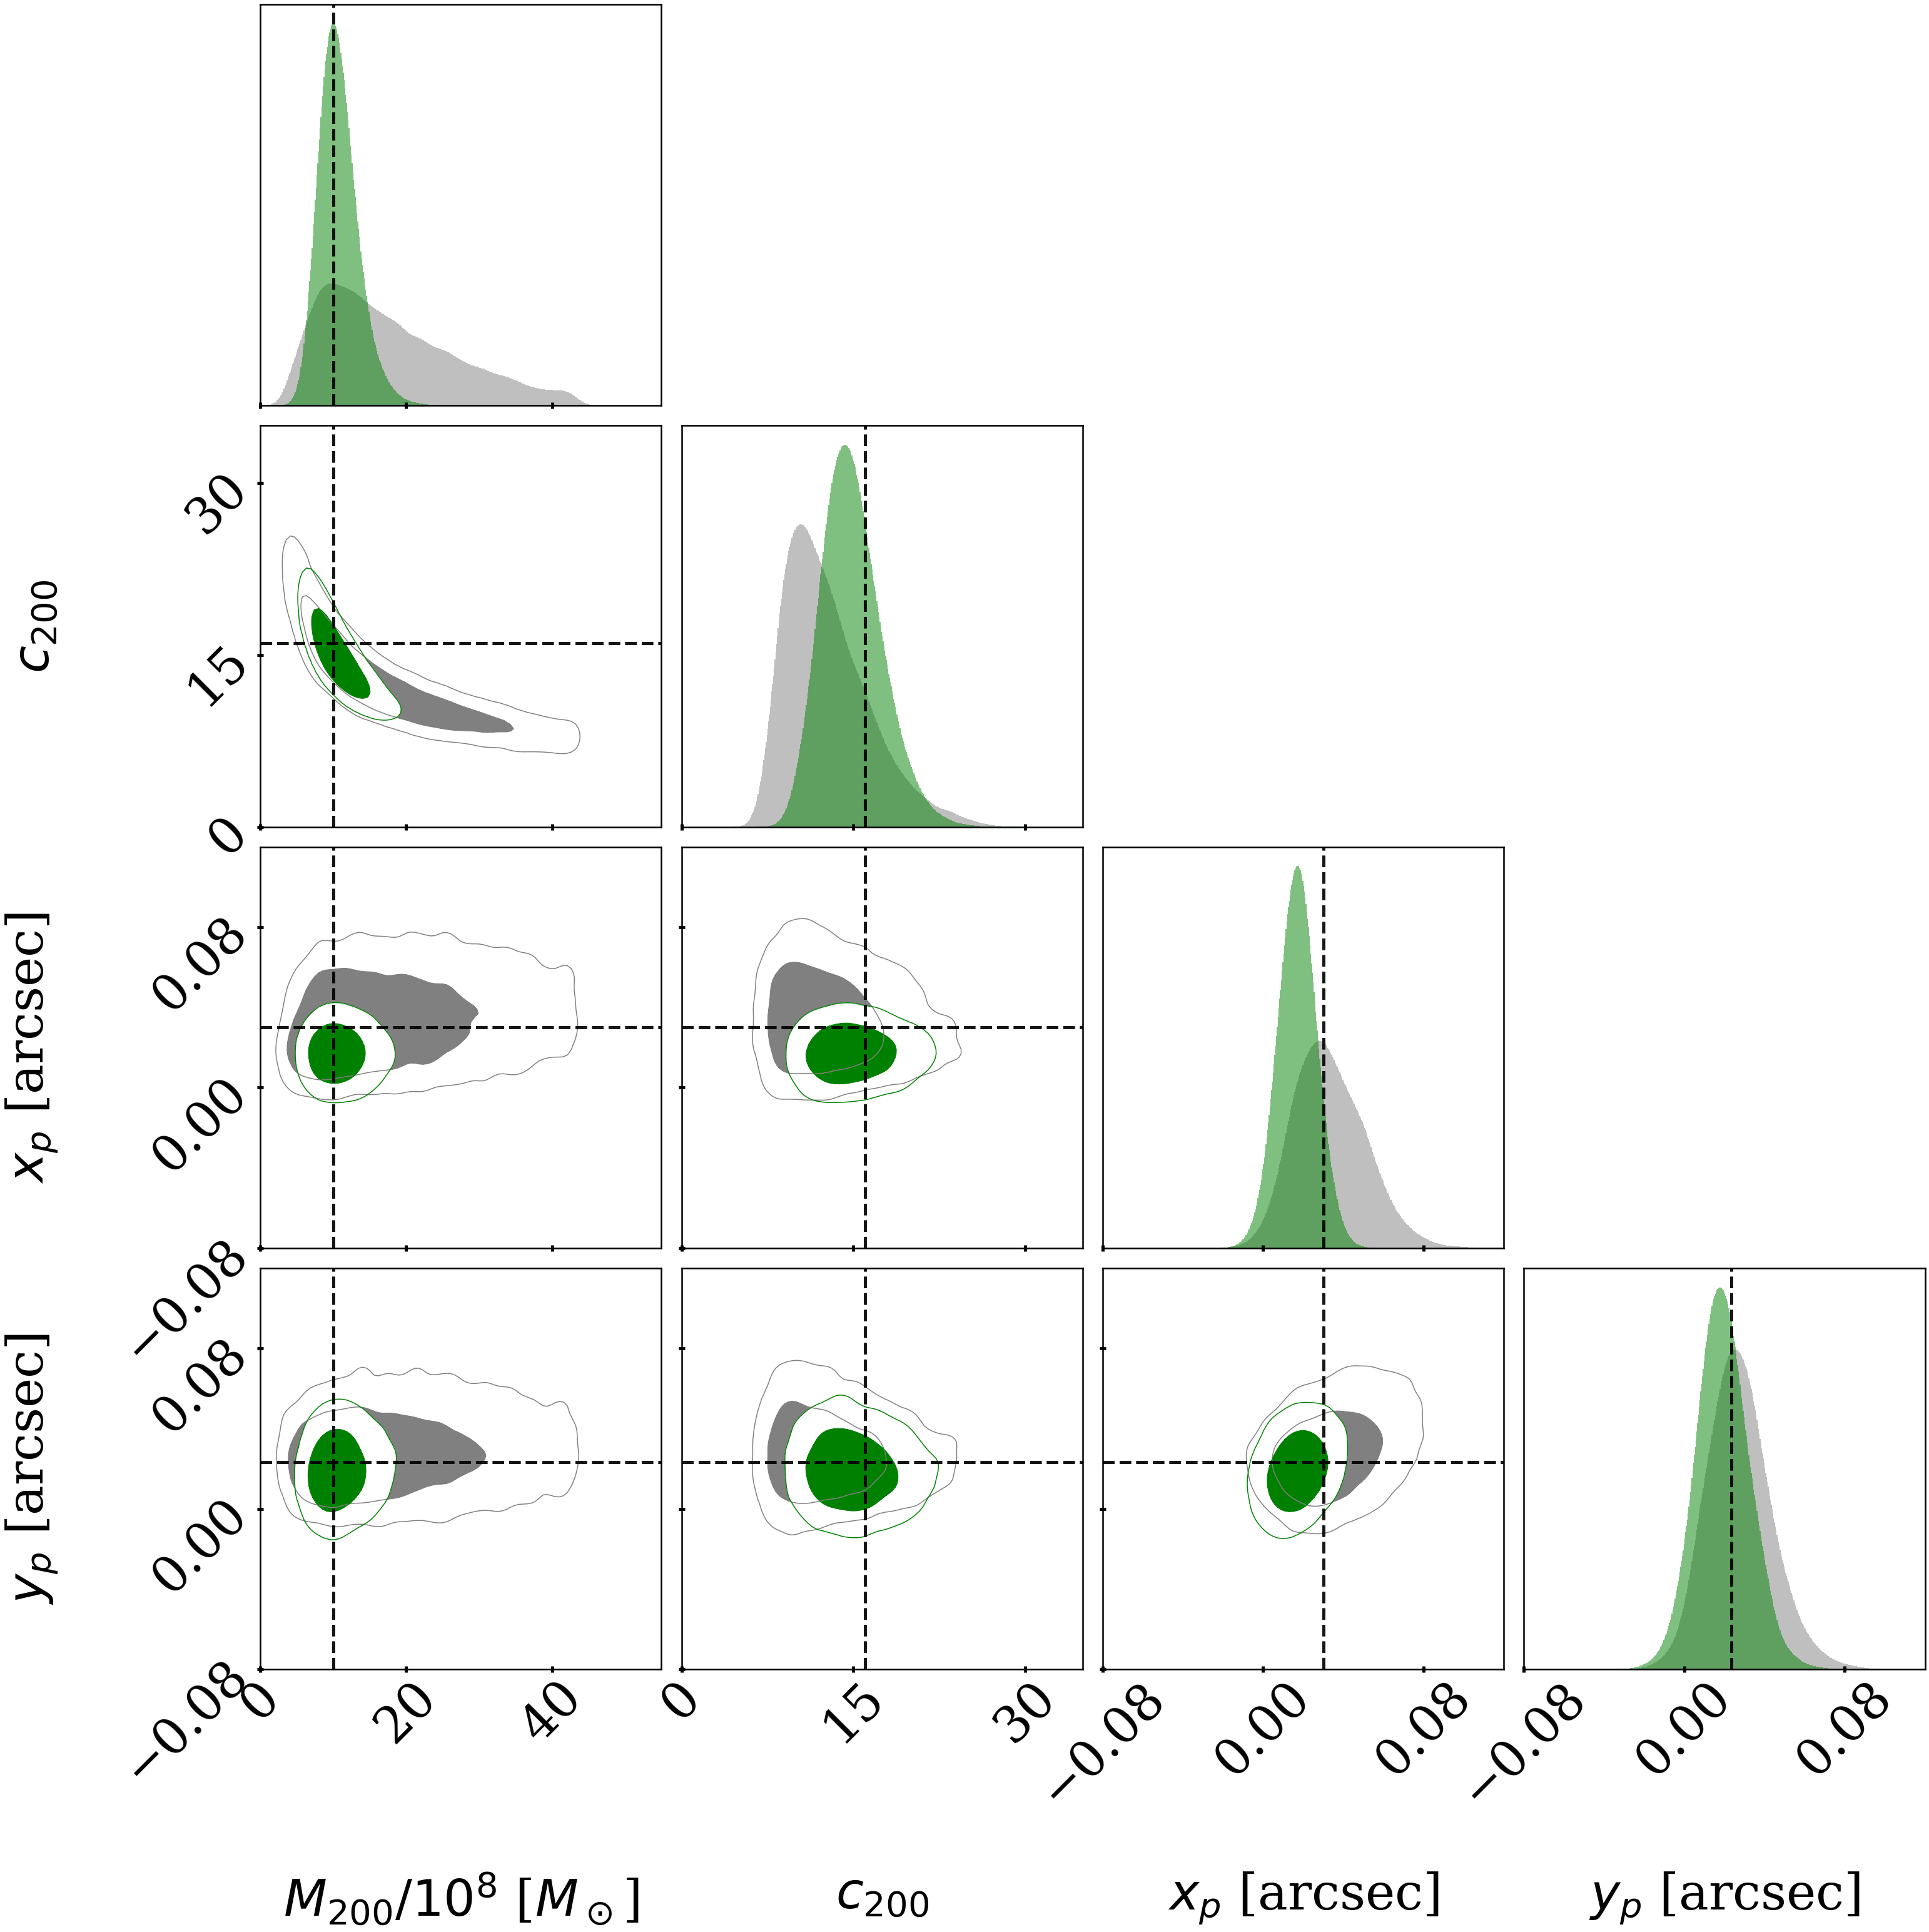

In [19]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 4

nlist = np.array(np.concatenate([np.arange(21,25)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_mass[nlist[i]])
    bestfpp[i] = bestf_70[nlist[i]]


bestftrue4 = np.array([10.,16.,xpp1,ypp1])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.2)*N,9*(1.2)*N))

span = [[0.,55.],[0.,35.],[-0.08,0.12],[-0.08,0.12]]

quant = [0.6826894921370859,0.9544997361036416]


intcplot2,intcbestplot2 = dresults70, bestftrue4
intcplot3,intcbestplot3 = dresults90, bestftrue4



tfig2a, taxes2a = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='black',labels=None,color='gray',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(intcplot3,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='black',labels=None,color='green',fig=[tfig2a, taxes2a],
                                  hist_kwargs=histdic,truth_kwargs=truedic)



for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()

# Black holes

In [20]:
dresults90 = load_obj('../smacs_0723/POINTMASS_POSA_with_10_90_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults80 = load_obj('../smacs_0723/POINTMASS_POSA_with_10_80_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')
dresults70 = load_obj('../smacs_0723/POINTMASS_POSA_with_10_70_16_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')


dresults90.samples[:,21] = dresults90.samples[:,21]/10.
dresults80.samples[:,21] = dresults80.samples[:,21]
dresults70.samples[:,21] = dresults70.samples[:,21]*10.

labls_mask_mass = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M/M_\mathrm{true}$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']



maxl_90, bestf_90, cv_90 = bestfit(dresults90)
maxl_80, bestf_80, cv_80 = bestfit(dresults80)
maxl_70, bestf_70, cv_70 = bestfit(dresults70)

3
(0.0, 78.23902419064439)
(0.0, 1703.4044270622564)
(0.0, 1701.1529708720334)


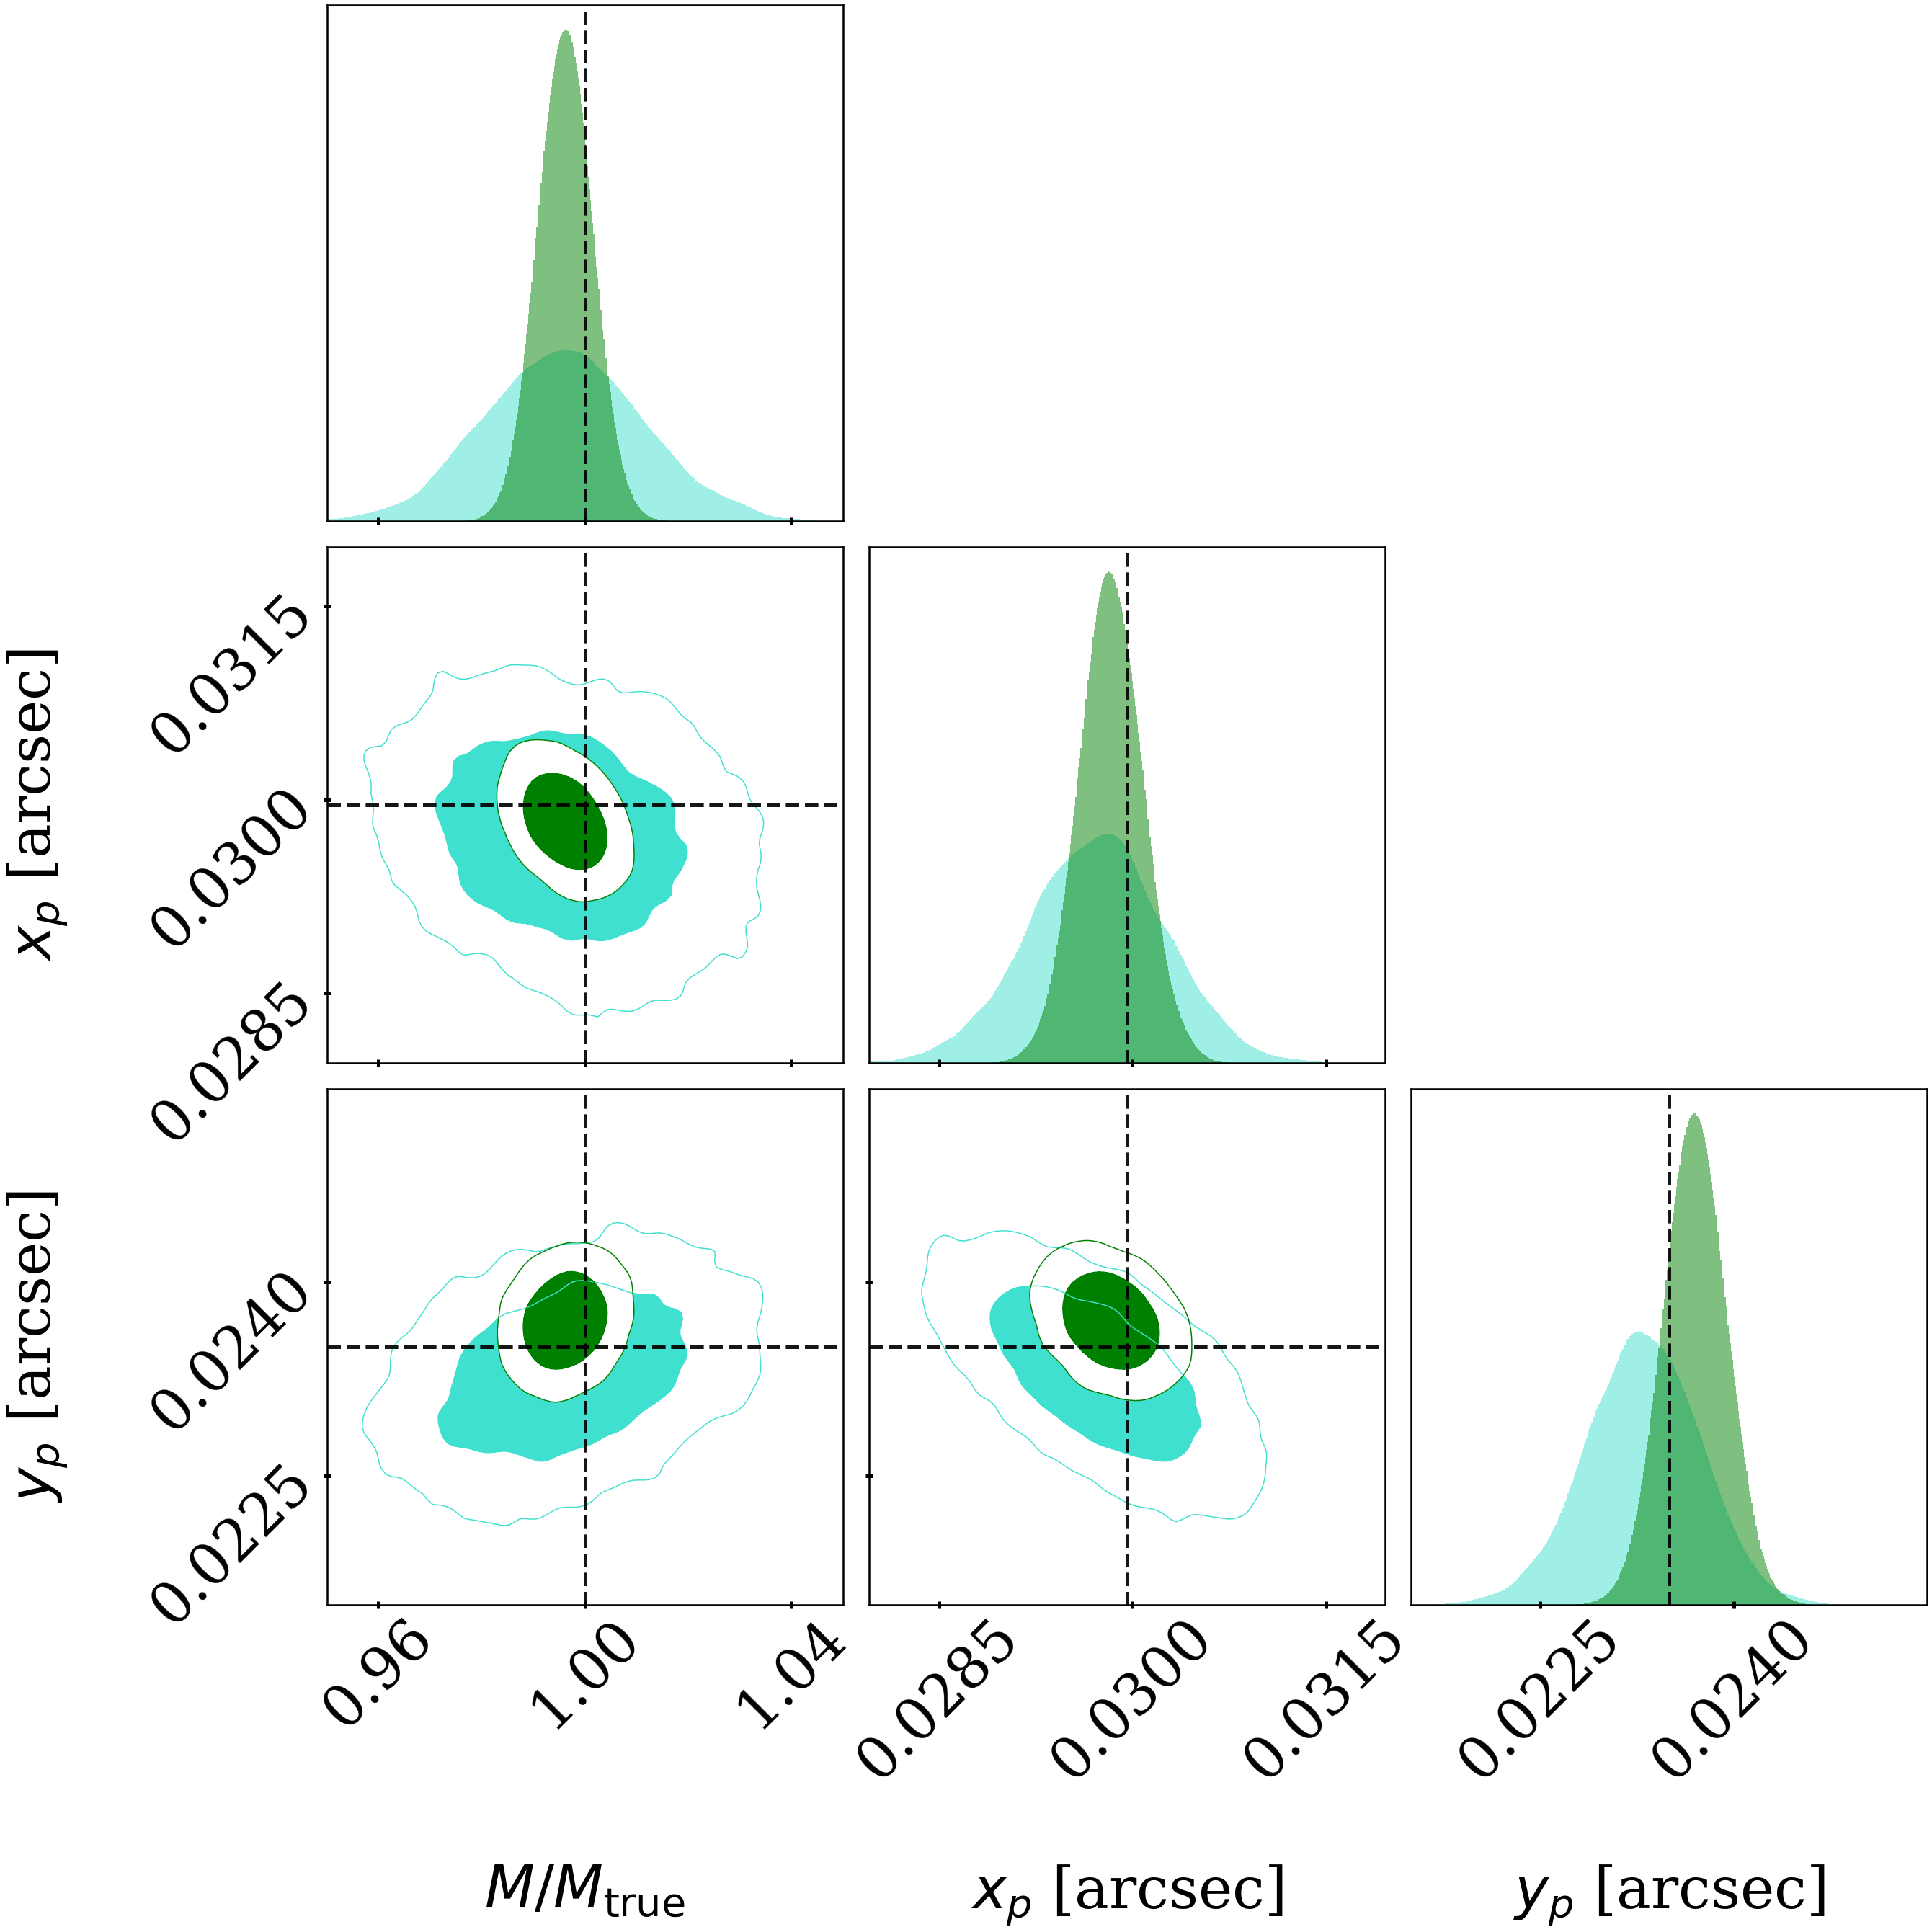

In [21]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}


N = 3

nlist = np.array(np.concatenate([np.arange(21,24)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_mass[nlist[i]])
    bestfpp[i] = bestfA[nlist[i]]

bestftrue0 = np.array([1.,xpp1,ypp1])
bestftrue1 = np.array([1.,xpp1,ypp1])
bestftrue2 = np.array([1.,xpp1,ypp1])
bestftrue3 = np.array([1.,xpp1,ypp1])
bestftrue4 = np.array([1.,xpp1,ypp1])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.4)*N,9*(1.4)*N))



span = [[0.95,1.05],[xpp1-0.002,xpp1+0.002],[ypp1-0.002,ypp1+0.002]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot5,intcbestplot5 = dresults90, bestftrue0
#intcplot1,intcbestplot1 = dresults85, bestftrue1
intcplot4,intcbestplot4 = dresults80, bestftrue2
#intcplot3,intcbestplot3 = dresults75, bestftrue3
intcplot2,intcbestplot2 = dresults70, bestftrue4




#tfig1, taxes1 = dyplot.cornerplot(intcplot1,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot1,truth_color='magenta',labels=None,color='magenta',fig=[tfig_, taxes_],
#                                  hist_kwargs=histdic,truth_kwargs=truedic)

#tfig2k, taxes2k = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot2,truth_color='black',labels=None,color='purple',fig=[tfig_, taxes_],
#                                  hist_kwargs=histdic,truth_kwargs=truedic,smooth=0.1)

#tfig20, taxes20 = dyplot.cornerplot(intcplot3,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot3,truth_color='darkorange',labels=None,color='darkorange',fig=[tfig2k, taxes2k],
#                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2u, taxes2u = dyplot.cornerplot(intcplot4,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot4,truth_color='black',labels=None,color='turquoise',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic)

tfig2, taxes2 = dyplot.cornerplot(intcplot5,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot5,truth_color='black',labels=None,color='green',fig=[tfig2u, taxes2u],
                                  hist_kwargs=histdic,truth_kwargs=truedic)


for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()

3
(0.0, 1.3132225562666662)
(0.0, 51.99697172309809)
(0.0, 69.14599798734822)


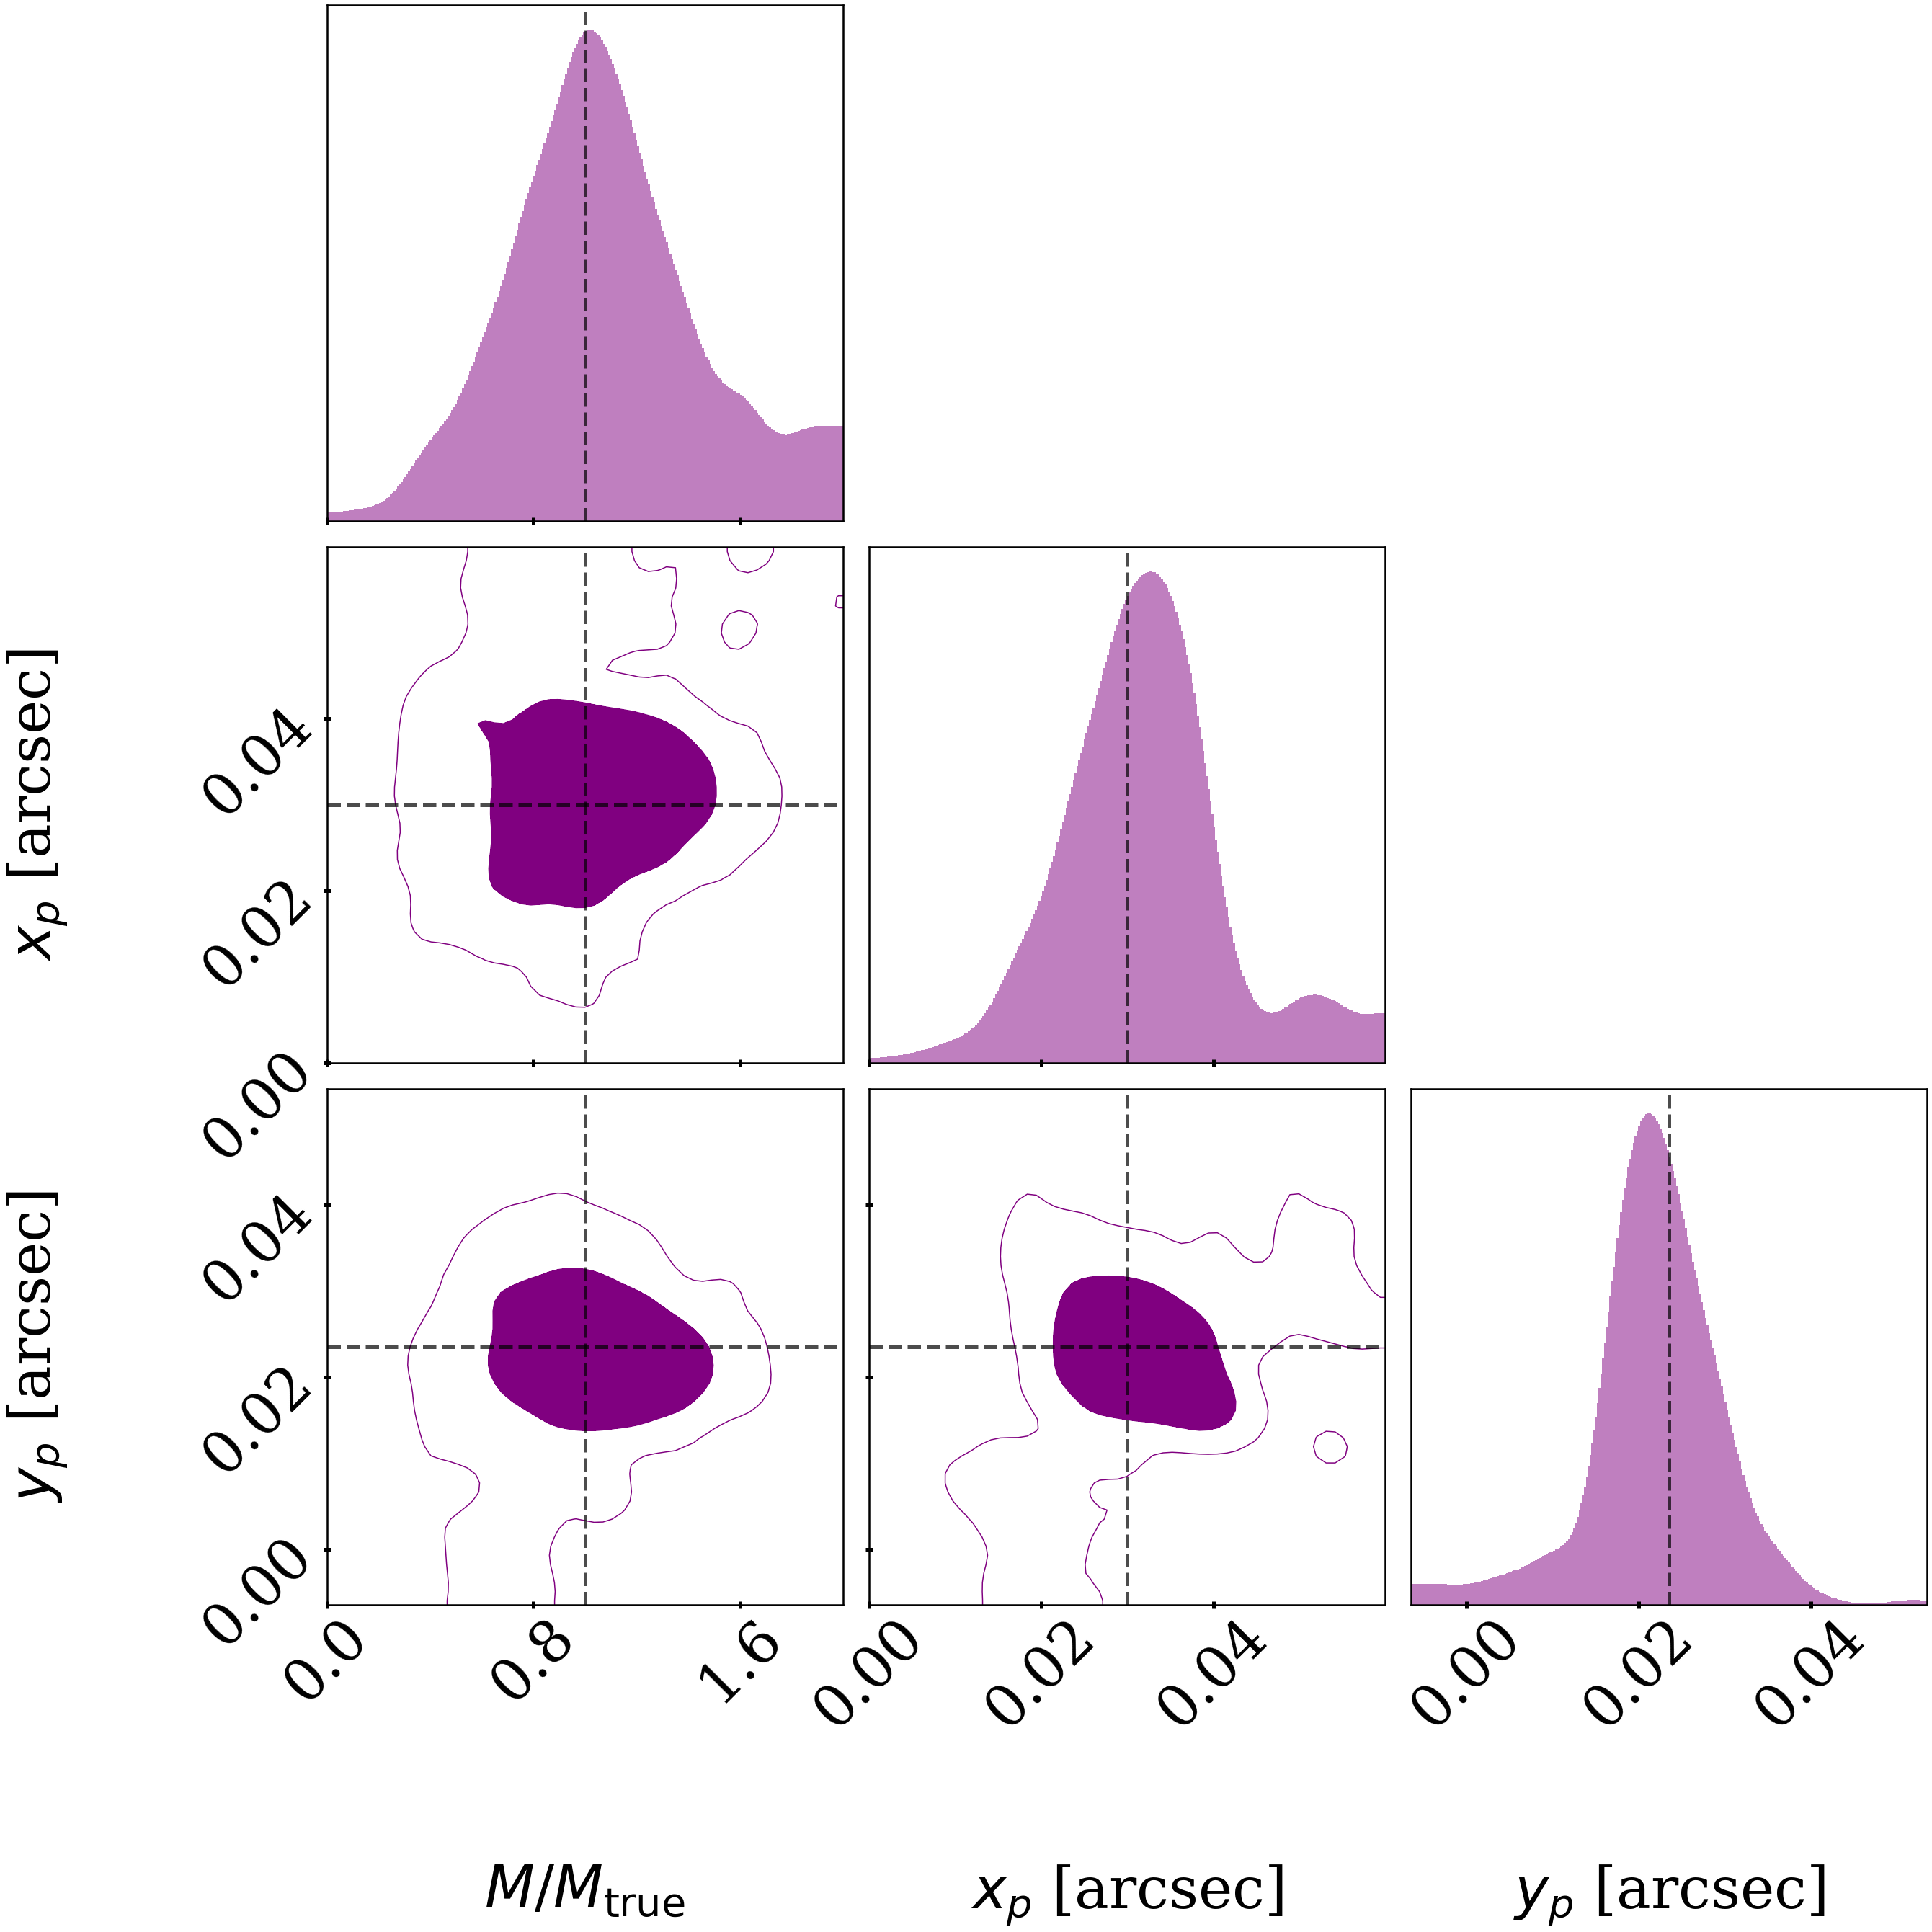

In [22]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}


N = 3

nlist = np.array(np.concatenate([np.arange(21,24)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_mass[nlist[i]])
    bestfpp[i] = bestfA[nlist[i]]

bestftrue0 = np.array([1.,xpp1,ypp1])
bestftrue1 = np.array([1.,xpp1,ypp1])
bestftrue2 = np.array([1.,xpp1,ypp1])
bestftrue3 = np.array([1.,xpp1,ypp1])
bestftrue4 = np.array([1.,xpp1,ypp1])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.4)*N,9*(1.4)*N))



span = [[0.,2.],[xpp1-0.03,xpp1+0.03],[ypp1-0.03,ypp1+0.03]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot5,intcbestplot5 = dresults90, bestftrue0
#intcplot1,intcbestplot1 = dresults85, bestftrue1
intcplot4,intcbestplot4 = dresults80, bestftrue2
#intcplot3,intcbestplot3 = dresults75, bestftrue3
intcplot2,intcbestplot2 = dresults70, bestftrue4




#tfig1, taxes1 = dyplot.cornerplot(intcplot1,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
#                                  truths=intcbestplot1,truth_color='magenta',labels=None,color='magenta',fig=[tfig_, taxes_],
#                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='black',labels=None,color='purple',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic,smooth=0.035)



for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()

In [23]:
dresults70 = load_obj('../smacs_0723/wide_prior_c_POINT_MASS_NFW_FIT_POSA_with_10_8_PERTURBED_FIXmur=1_3_images_SHAPE_SHAPEnmax18nmax28')


labls_mask_mass = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]',
              '$M_{200}/10^{7}$ [$M_\odot$]','$c_{200}$', '$x_p$ [arcsec]' , '$y_p$ [arcsec]']



#maxl_90, bestf_90, cv_90 = bestfit(dresults90)
#maxl_80, bestf_80, cv_80 = bestfit(dresults80)
maxl_70, bestf_70, cv_70 = bestfit(dresults70)


4
(0.0, 0.6545963200450554)
(0.0, 0.16187492299527023)
(0.0, 571.5189048088683)
(0.0, 632.1679315480286)


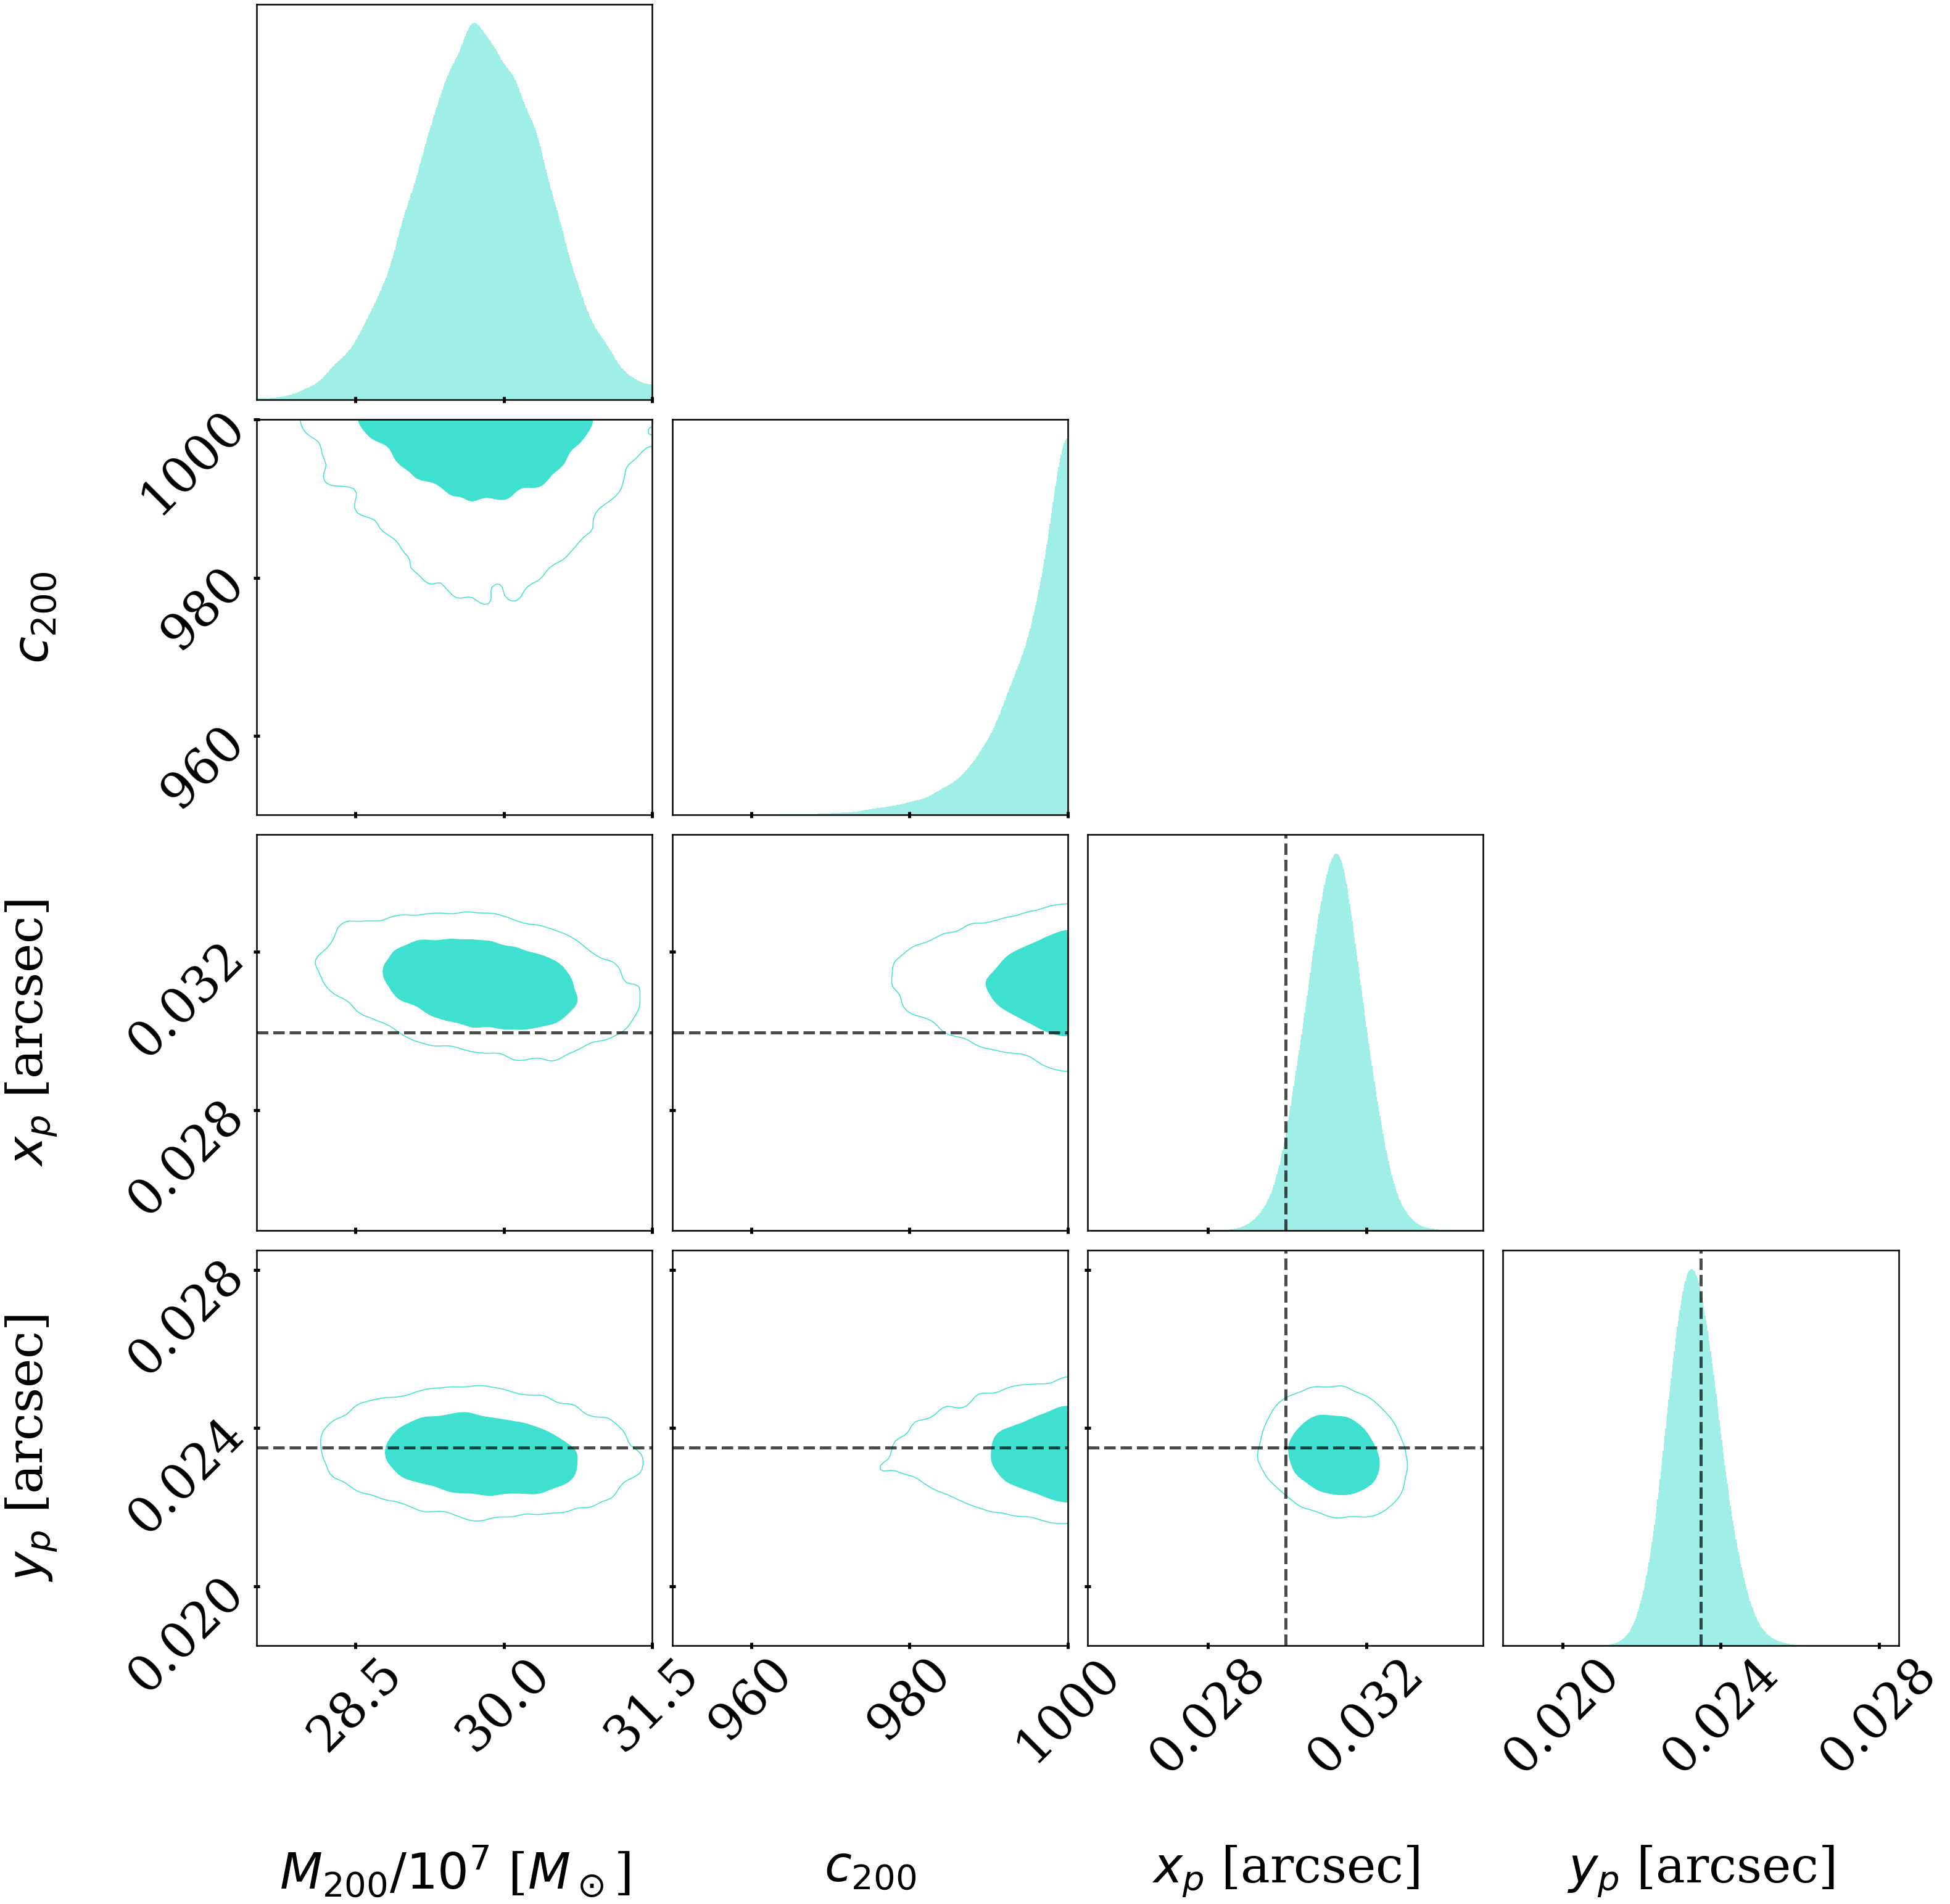

In [24]:
truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 4

nlist = np.array(np.concatenate([np.arange(21,25)]))
print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask_mass[nlist[i]])
    bestfpp[i] = bestf_70[nlist[i]]


bestftrue4 = np.array([-1.,-1.,xpp1,ypp1])


tfig_,taxes_= plt.subplots(N,N,figsize=(9*(1.2)*N,9*(1.2)*N))

span = [[27.5,31.5],[950.,1000.],[xpp1-0.005,xpp1+0.005],[ypp1-0.005,ypp1+0.005]]

quant = [0.6826894921370859,0.9544997361036416]


intcplot2,intcbestplot2 = dresults70, bestftrue4




tfig2, taxes2 = dyplot.cornerplot(intcplot2,span=span,dims=nlist,quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2,truth_color='black',labels=None,color='turquoise',fig=[tfig_, taxes_],
                                  hist_kwargs=histdic,truth_kwargs=truedic)



for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout',pad=0.)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j])
            taxes2[i,j].xaxis.set_label_coords(0.5,-0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i])
                taxes2[i,j].yaxis.set_label_coords(-0.5,0.5)
        
        
#        
#        taxes2[i,j].set_ylabel(taxes2[i,j].get_ylabel(),labelpad=100.)
        if j==i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            print(taxes2[i,j].get_ylim())
        if j<i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.tight_layout()
#taxes2[0,0].set_ylim(0.0, 0.35)
#taxes2[1,1].set_ylim(0.0, 0.13)
#taxes2[2,2].set_ylim(0.0, 70.)
#taxes2[3,3].set_ylim(0.0, 90.)
plt.show()